# General Index Data Pipeline Framework
Small scale testing of general index data pipeline & graph NLP visualization using a test dataset of ~750 manuscripts
across 2 topics: Antediluvian and Hennig86. 

---
Created 6/3/22 by Ian Hay   
Updated 7/23/22

https://medium.com/rapids-ai/accelerating-topic-modeling-with-rapids-and-bert-models-be9909eeed2    
https://medium.com/plotly/nlp-visualisations-for-clear-immediate-insights-into-text-data-and-outputs-9ebfab168d5b

### Imports
Dependencies

---
[Python 3.8+](https://www.python.org/downloads/release/python-380/)    
[Pandas](https://pandas.pydata.org/)   
[NumPy](https://numpy.org/)    
[NetworkX](https://networkx.org/)  
[pyvis](https://pyvis.readthedocs.io/en/latest/install.html)   
[scikit-learn](https://scikit-learn.org/stable/index.html)  
[seaborn](https://seaborn.pydata.org/)  
[nltk](https://www.nltk.org/)   
[gensim](https://pypi.org/project/gensim/)  
[spacy](https://pypi.org/project/spacy/)    

In [1]:
from time import time
import pandas as pd
import numpy as np
import seaborn as sns
import itertools
import re
import nltk
import ssl
import gensim
import spacy
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from collections import Counter
from pyvis import network as net
from pyvis.network import Network
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

/Users/ian/opt/anaconda3/envs/generalindexenv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
"""
Run this line in your python environment before running the code below: 

python -m spacy download en_core_web_sm

"""
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('stopwords')
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package stopwords to /Users/ian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Functions

In [3]:
# Data Processing -------------------------------------------------------------------------------------------

def getDocColumn(df, column, newColumnName):
    """
    Given a dataframe and a column of datatype list, constructs
    a new column newColumnName with the list joined into a single
    string and items separated by spaces (" ").
    """
    strDict = {}
    for row in range(len(df)):
        text = ". ".join(df.iloc[row][column])
        text = text + "."
        strDict[df.index[row]] = text
    dfStr = pd.Series(strDict, name=newColumnName)
    df[newColumnName] = dfStr

def getBagOfWordsDF(df, docColumn):
    """
    """
    countvec = CountVectorizer()
    X = countvec.fit_transform(df[docColumn])
    dfBOW = pd.DataFrame(X.toarray(),columns=countvec.get_feature_names_out())
    dfBOW.set_index(df.index, inplace=True)
    return dfBOW

def getNounsAndVerbs(df, column, newColumnName):
    """
    Utilizes Spacy to extract nouns and verbs from ngrams
    and build a new column with only these terms.
    """
    nounAndVerbDict = {}
    for row in range(len(df)):
        text = ". ".join(df.iloc[row][column])
        doc = nlp(text)
        nounList = [chunk.text for chunk in doc.noun_chunks]
        verbList = [token.lemma_ for token in doc if token.pos_ == "VERB"]
        nounAndVerbDict[df.index[row]] = nounList + verbList
    dfNounAndVerb = pd.Series(nounAndVerbDict, name=newColumnName)
    df[newColumnName] = dfNounAndVerb

def partOfSpeechTagging(texts, POS=["NOUN", "ADJ", "ADV", "VERB"]):
    """
    https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#16buildingldamalletmodel
    """
    textTagged = []
    for text in texts:
        doc = nlp(text)
        text_ = [token.lemma_ for token in doc if token.pos_ in POS]
        textTagged.append(" ".join(text_))
    return textTagged

def removeStopWords(texts):
    """
    Takes in texts (words in a single string separated by spaces).
    https://stackoverflow.com/questions/29523254/python-remove-stop-words-from-pandas-dataframe
    """
    textParsed = []
    from nltk.corpus import stopwords
    _stopWords = stopwords.words("english")
    _stopWords.extend(["-pron-", "pron"]) # these words appears in many ngrams without apparent meaning
    textParsed = texts.apply(lambda x: " ".join([word for word in x.split() if word not in (list(_stopWords))]))
    return textParsed

def getUniqueWordsColumn(df, column, newColumnName, nonWords=[]):
    """
    Given a dataframe and column, constructs a new column with name newColumnName
    of the unique words in  df[column].
    The object in  df[column]  must be a list of strings.
    Returns the updated dataframe.
    """

    ### deprecated ###

    df[newColumnName] = df[column]
    for row in range(len(df[newColumnName])):
        df[newColumnName][row] = df[column].iloc[row]
        string_list = []
        for string in df[newColumnName].iloc[row]:
            string_list.append(string.split(" ")) # splits words into list of individual word strings
        string_list = list(itertools.chain(*string_list)) # concatenates nested list into 1D list
        string_list = list(set(string_list)) # grabs only unique string items
        for nonword in nonWords:
            if nonword in string_list:
                string_list.remove(nonword)
        df.loc[newColumnName].iloc[row] = string_list
    return df

def buildAdjacencyMatrixByColumn(df, column):
    """
    Given a dataframe and a column, constructs an adjacency matrix
    of size [n x n] where  n  is the number of rows of the dataframe.
    The adjacency matrix edge weights represent the number of similar elements.
    The datatype in  df[column]  must be a list.
    """
    n = len(df[column])
    adjMatrix = np.zeros((n, n))
    for n1 in range(n):
        ngram1 = df[column].iloc[n1]
        for n2 in range(n):
            ngram2 = df[column].iloc[n2]
            numSimilar = numSimilarStrings(ngram1, ngram2)
            if n1 != n2 & numSimilar > 0: # removes recursive edges
                adjMatrix[n1][n2] = numSimilar 
    return adjMatrix

def buildAdjacencyListByColumn(df, column):
    """
    Given a dataframe and a column, constructs an adjacency list
    as a nestd dictionary with  n  keys in the outermost dict, where
    n  is the number of rows in the dataframe.
    The adjacency list edge weights represent the number of similar elements.
    The datatype in  df[column]  must be a list.
    """
    n = len(df[column])

    adjDict = {} # consider using the hash to represent nodes instead of numbers
    for n1 in range(n):

        nodeDict = {}
        ngram1 = df[column].iloc[n1]
        for n2 in range(n):
            ngram2 = df[column].iloc[n2]
            numSimilar = numSimilarStrings(ngram1, ngram2)
            if n1 != n2 & numSimilar > 0: # removes recursive edges
                nodeDict[n2] = {"weight" : numSimilar} # https://networkx.org/documentation/stable/reference/generated/networkx.convert.from_dict_of_dicts.html
        adjDict[n1] = nodeDict

    return adjDict

def buildAdjacencyMatrixByCoOccurence(dfBOW):
    """
    """
    X = np.array(dfBOW.values)
    coocc = np.dot(X.T, X)
    np.fill_diagonal(coocc, 0)
    return coocc

def buildDocVectorMatrixByColumn(df, docColumn, vectorSize=50, minCount=2, iterations=100, maxLen=30):
    """
    Given a dataframe and a column storing documents,
    trains a gensim doc2vec model and outputs
    the vector matrix.
    """
    def read_corpus(documents):
        for i, plot in enumerate(documents):
            yield gensim.models.doc2vec.TaggedDocument(gensim.utils.simple_preprocess(plot, max_len=maxLen), [i])

    train_corpus = list(read_corpus(df[docColumn]))
    model = gensim.models.doc2vec.Doc2Vec(vector_size=vectorSize, min_count=minCount, epochs=iterations) # hyperparameters
    model.build_vocab(train_corpus)
    model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)
    docVectors = model.dv.vectors
    return docVectors

def buildAdjacencyMatrixByCosineSimilarity(vecMatrix):
    """
    Given a vector matrix, computes the cosine similarity score
    between rows of the matrix and stores the values in an
    adjacency matrix.
    """
    n = len(vecMatrix)
    cosSimMatrix = np.zeros((n,n))
    for row in range(n):
        a = vecMatrix[row]
        for otherRow in range(n):
            b = vecMatrix[otherRow]
            cosSimMatrix[row][otherRow] = np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))
    np.fill_diagonal(cosSimMatrix, 0)
    return cosSimMatrix

In [4]:
# Utility --------------------------------------------------------------------------------------------------

def loadTextFileIntoDataframe(filepath, columns, splittingChar="\t"):
    """
    Opens the given filepath into a pandas dataframe.
    Splits the list by the denoted character, by default tab.
    Returns a pandas dataframe.
    """
    with open(filepath) as file:
        data = file.readlines()
    df = pd.DataFrame(columns=columns)
    for line in data:
        lineSplit = [line.split(splittingChar)]
        if len(lineSplit[0]) < len(columns):
            for x in range(len(columns) - len(lineSplit[0])):
                lineSplit[0].append("0")
        lineDF = pd.DataFrame(lineSplit, columns=columns)
        df = pd.concat([df, lineDF], axis=0, ignore_index=True)
    return df

def numSimilarStrings(stringList1, stringList2):
    """
    Given two lists of strings, returns the number of strings they both share.
    In other words, the size of the subset intersection of stringList1 and stringList2.
    """

    # is there a faster way to do this with sets?

    count = 0
    for string in stringList1:
        if string in stringList2:
            count = count + 1
    return count

def subtractListsOfInts(_list1, _list2):
    """
    Given two lists of items, returns a list of items
    in _list1 and not in _list2.
    Utilizes collections.Counter
    Returns a list of items.

    https://stackoverflow.com/questions/2070643/subtracting-two-lists-in-python
    """
    _set1 = Counter(_list1)
    _set2 = Counter(_list2)
    _set1_2 = _set1 - _set2
    return list(_set1_2.elements())

def cosineSimilarityNumMostSimilar(model, word, target_list, num):
    """
    https://towardsdatascience.com/a-beginners-guide-to-word-embedding-with-gensim-word2vec-model-5970fa56cc92
    """
    cosine_dict ={}
    word_list = []
    a = model[word]
    for item in target_list :
        if item != word :
            b = model [item]
            cos_sim = np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))
            cosine_dict[item] = cos_sim
    dist_sort=sorted(cosine_dict.items(), key=lambda dist: dist[1],reverse = True) ## in descending order 
    for item in dist_sort:
        word_list.append((item[0],  item[1]))
    return word_list[0:num]

def standardizeDataColumn(df, column, newColumnName):
    """
    Standardizes the column of the dataframe df.
    Adds the new column newColumnName to the dataframe inplace.
    Utilizes SKLearn.preprocessing.standardscaler.
    Mean is 0, variance is 1
    """
    scaler = StandardScaler()
    scaledSeries = pd.Series(np.reshape(scaler.fit_transform(np.array(df[column]).reshape(-1, 1)), (-1)), name=newColumnName, index=df.index)
    scaledSeries = scaledSeries + 1 # adding 1 scales most (~98%) to be in range [0, 2] for graphing purposes
    df[newColumnName] = scaledSeries


In [5]:
# Visualization -------------------------------------------------------------------------------------------

def visualizeNetworkHTML(_graph, _filename, _width="1920px", _height="1080px", _physics=False):
    """
    Given a NetworkX graph and the filename to save to, builds an HTML
    graph of that network. Optional parameters are width and height of graph.
    Uses pyvis to build an interactive HTML graph of a NetworkX graph.
    Uses NetworkX for graph storage.
    """
    _net = Network(width=_width, height=_height, notebook=True)
    _net.toggle_physics(_physics)
    _net.barnes_hut()
    _net.from_nx(_graph)
    _net.show(_filename)

def plot_top_words_one_topic(model, feature_names, n_top_words, title):
    """
    https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py
    """
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        plt.barh(top_features, weights, height=0.7)
        plt.tick_params(axis="both", which="major", labelsize=12)
        plt.suptitle(title, fontsize=25)
    plt.show()

def plot_top_words(model, feature_names, n_top_words, title, n_topics):
    """
    https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py
    """
    fig, axes = plt.subplots(1, n_topics, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 20})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=25)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

def drawNetworkgraph(networkx_graph,notebook=True,output_filename='graph.html',show_buttons=True,only_physics_buttons=False,
                height=None,width=None,bgcolor=None,font_color=None,pyvis_options=None):
    """
    https://gist.github.com/maciejkos/e3bc958aac9e7a245dddff8d86058e17
    
    This function accepts a networkx graph object,
    converts it to a pyvis network object preserving its node and edge attributes,
    and both returns and saves a dynamic network visualization.
    Valid node attributes include:
        "size", "value", "title", "x", "y", "label", "color".
        (For more info: https://pyvis.readthedocs.io/en/latest/documentation.html#pyvis.network.Network.add_node)
    Valid edge attributes include:
        "arrowStrikethrough", "hidden", "physics", "title", "value", "width"
        (For more info: https://pyvis.readthedocs.io/en/latest/documentation.html#pyvis.network.Network.add_edge)
    Args:
        networkx_graph: The graph to convert and display
        notebook: Display in Jupyter?
        output_filename: Where to save the converted network
        show_buttons: Show buttons in saved version of network?
        only_physics_buttons: Show only buttons controlling physics of network?
        height: height in px or %, e.g, "750px" or "100%
        width: width in px or %, e.g, "750px" or "100%
        bgcolor: background color, e.g., "black" or "#222222"
        font_color: font color,  e.g., "black" or "#222222"
        pyvis_options: provide pyvis-specific options (https://pyvis.readthedocs.io/en/latest/documentation.html#pyvis.options.Options.set)
    """

    # make a pyvis network
    network_class_parameters = {"notebook": notebook, "height": height, "width": width, "bgcolor": bgcolor, "font_color": font_color}
    pyvis_graph = net.Network(**{parameter_name: parameter_value for parameter_name, parameter_value in network_class_parameters.items() if parameter_value})

    # for each node and its attributes in the networkx graph
    for node,node_attrs in networkx_graph.nodes(data=True):
        pyvis_graph.add_node(node,**node_attrs)

    # for each edge and its attributes in the networkx graph
    for source,target,edge_attrs in networkx_graph.edges(data=True):
        # if value/width not specified directly, and weight is specified, set 'value' to 'weight'
        if not 'value' in edge_attrs and not 'width' in edge_attrs and 'weight' in edge_attrs:
            # place at key 'value' the weight of the edge
            edge_attrs['value']=edge_attrs['weight']
        # add the edge
        pyvis_graph.add_edge(source,target,**edge_attrs)

    # turn buttons on
    if show_buttons:
        if only_physics_buttons:
            pyvis_graph.show_buttons(filter_=['physics'])
        else:
            pyvis_graph.show_buttons()

    # pyvis-specific options
    if pyvis_options:
        pyvis_graph.set_options(pyvis_options)

    # return and also save
    return pyvis_graph.show(output_filename)

def display_closestwords_tsnescatterplot(model, word, size):
    """
    https://towardsdatascience.com/a-beginners-guide-to-word-embedding-with-gensim-word2vec-model-5970fa56cc92
    """
    arr = np.empty((0,size), dtype='f')
    word_labels = [word]
    close_words = model.similar_by_word(word)
    arr = np.append(arr, np.array([model[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
            
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)
    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    plt.scatter(x_coords, y_coords)
    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
        plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
        plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
        plt.show()


### Building Dataframe and Processing Data

In [6]:
# hard coded things
columnListNGrams = ["hash", "ngram", "ngram_lc", "ngram_tokens", "ngram_count", "term_freq", "doc_count", "date_added"]
columnListKeywords = ["hash", "keywords", "keywords_lc", "keyword_tokens", "keyword_score", "doc_count", "insert_date"]

non_words = ["a", "at", "an", "am", "and", "that", "like", "for", "by", "i", "in", "of", "or", "be", "use", "as", "on", "the", "to", "with", "-pron-"]

filenameAnteNGrams = "data/doc_ngrams/sample.fgrep.antediluvian.txt"
filepathHennigNGrams = "data/doc_ngrams/sample.fgrep.Hennig86.txt"
filenameAnteKeywords = "data/doc_keywords/sample.fgrep.antediluvian.txt"

In [7]:
"""
# load test files into dataframe

indexCol = columnListNGrams[0]
df_antedivulian = loadTextFileIntoDataframe(filepath=filenameAnteNGrams, columns=columnListNGrams)
df_hennig = loadTextFileIntoDataframe(filepath=filepathHennigNGrams, columns=columnListNGrams)
df_antedivulian["topic"] = "antediluvian"
df_hennig["topic"] = "hennig86"
df = pd.concat([df_antedivulian, df_hennig])
# save the data for later use
df.to_csv("test_data.csv")

# process data columns
df["ngram_lc_tagged"] = partOfSpeechTagging(df["ngram_lc"])
df["ngram_lc_tagged"] = removeStopWords(df["ngram_lc_tagged"])
df = df.groupby(indexCol).agg(list)

yakeScoreCol = columnListNGrams[5]
for n in range(len(df)):
    term_freq_list = df[yakeScoreCol].iloc[n]
    df[yakeScoreCol].iloc[n] = term_freq_list[0]
    df["topic"].iloc[n] = df["topic"].iloc[n][0]
    if (len(df["ngram_lc_tagged"].iloc[n])) == 0: # if there are no noun/verb phrases from spacy preprocessing
        df["ngram_lc_tagged"][n] = df["ngram_lc"].iloc[n] # replace it with the lowercase ngram(s)
df[yakeScoreCol] = df[yakeScoreCol].astype(float)

standardizeDataColumn(df, yakeScoreCol, "normalized_term_freq")
getDocColumn(df, "ngram_lc_tagged", "ngram_lc_tagged_doc")
getDocColumn(df, "ngram_lc", "ngram_lc_doc")
df["topic_num"] = (df["topic"] == "antediluvian").astype(int)

# save the dataframe for later use
df.to_csv("test_data_processed.csv")

df.head()
"""

'\n# load test files into dataframe\n\nindexCol = columnListNGrams[0]\ndf_antedivulian = loadTextFileIntoDataframe(filepath=filenameAnteNGrams, columns=columnListNGrams)\ndf_hennig = loadTextFileIntoDataframe(filepath=filepathHennigNGrams, columns=columnListNGrams)\ndf_antedivulian["topic"] = "antediluvian"\ndf_hennig["topic"] = "hennig86"\ndf = pd.concat([df_antedivulian, df_hennig])\n# save the data for later use\ndf.to_csv("test_data.csv")\n\n# process data columns\ndf["ngram_lc_tagged"] = partOfSpeechTagging(df["ngram_lc"])\ndf["ngram_lc_tagged"] = removeStopWords(df["ngram_lc_tagged"])\ndf = df.groupby(indexCol).agg(list)\n\nyakeScoreCol = columnListNGrams[5]\nfor n in range(len(df)):\n    term_freq_list = df[yakeScoreCol].iloc[n]\n    df[yakeScoreCol].iloc[n] = term_freq_list[0]\n    df["topic"].iloc[n] = df["topic"].iloc[n][0]\n    if (len(df["ngram_lc_tagged"].iloc[n])) == 0: # if there are no noun/verb phrases from spacy preprocessing\n        df["ngram_lc_tagged"][n] = df["ng

In [7]:
# read the processed data CSV
df = pd.read_csv("test_data_processed_grouped.csv")
df.set_index("hash", inplace=True)
# https://stackoverflow.com/questions/63200863/how-to-convert-the-datatype-of-a-column-from-string-to-list-in-pandas
df['ngram'] = df['ngram'].apply(lambda cell:
                                      ''.join(c for c in cell if c not in "'[]").split(', '))
df['ngram_lc'] = df['ngram_lc'].apply(lambda cell:
                                      ''.join(c for c in cell if c not in "'[]").split(', '))
df['ngram_lc_tagged'] = df['ngram_lc_tagged'].apply(lambda cell:
                                      ''.join(c for c in cell if c not in "'[]").split(', '))
df.head()

ngram  \
hash                                                                                          
3002e8a37ec9d00a67bdf0004b8628c35d72068d              [antediluvian, antediluvian humanity]   
3005b3bf055ddcb3c25e4742a72ee16728934efd  [antediluvian, antediluvian refrain, follow by...   
3005ebfe5508340797dbfcce8454f3d3f6f76eb1  [antediluvian, antediluvian dream, cave of -PR...   
30064ae161de1e9a96992be108c195796f13e72a  [Hennig86 program, routine in the Hennig86, ro...   
30136ab3788ab8e8be6b939901ec669a41ef896a                                     [antediluvian]   

                                                                                   ngram_lc  \
hash                                                                                          
3002e8a37ec9d00a67bdf0004b8628c35d72068d              [antediluvian, antediluvian humanity]   
3005b3bf055ddcb3c25e4742a72ee16728934efd  [antediluvian, antediluvian refrain, follow by...   
3005ebfe5508340797dbfcce8454f3d3f6f76eb1  [antediluvian, antediluvian dream, cave of -pr...   
30064ae161de1e9a96992be108c195796f13e72a  [hennig86 program, routine in the hennig86, ro...   
30136ab3788ab8e8be6b939901ec669a41ef896a                                     [antediluvian]   

                                                       ngram_tokens  \
hash                                                                  
3002e8a37ec9d00a67bdf0004b8628c35d72068d                 ['1', '2']   
3005b3bf055ddcb3c25e4742a72ee16728934efd       ['1', '2', '4', '5']   
3005ebfe5508340797dbfcce8454f3d3f6f76eb1  ['1', '2', '4', '5', '5']   
30064ae161de1e9a96992be108c195796f13e72a       ['2', '4', '5', '1']   
30136ab3788ab8e8be6b939901ec669a41ef896a                      ['1']   

                                                        ngram_count  \
hash                                                                  
3002e8a37ec9d00a67bdf0004b8628c35d72068d                 ['1', '1']   
3005b3bf055ddcb3c25e4742a72ee16728934efd       ['1', '1', '1', '1']   
3005ebfe5508340797dbfcce8454f3d3f6f76eb1  ['1', '1', '1', '1', '1']   
30064ae161de1e9a96992be108c195796f13e72a       ['1', '1', '1', '1']   
30136ab3788ab8e8be6b939901ec669a41ef896a                      ['1']   

                                          term_freq  \
hash                                                  
3002e8a37ec9d00a67bdf0004b8628c35d72068d   0.000010   
3005b3bf055ddcb3c25e4742a72ee16728934efd   0.000281   
3005ebfe5508340797dbfcce8454f3d3f6f76eb1   0.000091   
30064ae161de1e9a96992be108c195796f13e72a   0.000198   
30136ab3788ab8e8be6b939901ec669a41ef896a   0.000051   

                                                          doc_count  \
hash                                                                  
3002e8a37ec9d00a67bdf0004b8628c35d72068d                 ['1', '1']   
3005b3bf055ddcb3c25e4742a72ee16728934efd       ['1', '1', '1', '1']   
3005ebfe5508340797dbfcce8454f3d3f6f76eb1  ['1', '1', '1', '1', '1']   
30064ae161de1e9a96992be108c195796f13e72a       ['1', '1', '1', '1']   
30136ab3788ab8e8be6b939901ec669a41ef896a                      ['1']   

                                                                                 date_added  \
hash                                                                                          
3002e8a37ec9d00a67bdf0004b8628c35d72068d                                 ['\\N\n', '\\N\n']   
3005b3bf055ddcb3c25e4742a72ee16728934efd               ['\\N\n', '\\N\n', '\\N\n', '\\N\n']   
3005ebfe5508340797dbfcce8454f3d3f6f76eb1  ['2021-09-03\n', '2021-09-03\n', '2021-09-03\n...   
30064ae161de1e9a96992be108c195796f13e72a               ['\\N\n', '\\N\n', '\\N\n', '\\N\n']   
30136ab3788ab8e8be6b939901ec669a41ef896a                                          ['\\N\n']   

                                                 topic  \
hash                                                     
3002e8a37ec9d00a67bdf0004b8628c35d72068d  antediluvian   
3005b3bf055ddcb3c25e4742a72ee16728

In [8]:
# creates a list of all words that appear in the dataset

from itertools import chain
masterTermList = []
for eachList in df["ngram_lc"].values:
    splitList = []
    for string in eachList:
        splitList.append(string.split(" "))
    masterTermList.append(splitList)
firstNest = list(chain(*masterTermList))
secondNest = list(chain(*firstNest))
masterTerms = list(dict.fromkeys(secondNest))

In [9]:
# count number of times each word appears in an ngram
dfBoW = getBagOfWordsDF(df, "ngram_lc_doc")
dfBoWTag = getBagOfWordsDF(df, "ngram_lc_tagged_doc")
wordCountDict = {}
wordCountDictTag = {}
for column in dfBoW.columns:
    wordCountDict[column] = np.sum(dfBoW[column])
for column in dfBoWTag.columns:
    wordCountDictTag[column] = np.sum(dfBoWTag[column])

In [10]:
# count number of times each ngram appears in the corpus
df_raw = pd.read_csv("test_data.csv")
df_tagged = pd.read_csv("test_data_processed.csv")
ngramDict = {}
ngramTaggedDict = {}
for n in range(len(df_raw.index)):
    ngram = df_raw["ngram_lc"][n]
    if ngram in list(ngramDict.keys()):
        ngramDict[ngram] = ngramDict[ngram] + 1
    else:
        ngramDict[ngram] = 1

for n in range(len(df_tagged.index)):
    ngram = str(df_tagged["ngram_lc_tagged"][n])
    if ngram in list(ngramTaggedDict.keys()):
        ngramTaggedDict[ngram] = ngramTaggedDict[ngram] + 1
    else:
        ngramTaggedDict[ngram] = 1

In [11]:
# count number of times ngrams of specified lengths appear
unigramDict = dict((k, ngramDict[k]) for k in list(ngramDict.keys()) if len(k.split(" ")) == 1)
bigramDict = dict((k, ngramDict[k]) for k in list(ngramDict.keys()) if len(k.split(" ")) == 2)
trigramDict = dict((k, ngramDict[k]) for k in list(ngramDict.keys()) if len(k.split(" ")) == 3)
fourgramDict = dict((k, ngramDict[k]) for k in list(ngramDict.keys()) if len(k.split(" ")) == 4)
fivegramDict = dict((k, ngramDict[k]) for k in list(ngramDict.keys()) if len(k.split(" ")) == 5)

# count number of times tagged ngrams of specified lengths appear
unigramDictTagged = dict((k, ngramTaggedDict[k]) for k in list(ngramTaggedDict.keys()) if len(k.split(" ")) == 1)
bigramDictTagged = dict((k, ngramTaggedDict[k]) for k in list(ngramTaggedDict.keys()) if len(k.split(" ")) == 2)
trigramDictTagged = dict((k, ngramTaggedDict[k]) for k in list(ngramTaggedDict.keys()) if len(k.split(" ")) == 3)
fourgramDictTagged = dict((k, ngramTaggedDict[k]) for k in list(ngramTaggedDict.keys()) if len(k.split(" ")) == 4)
fivegramDictTagged = dict((k, ngramTaggedDict[k]) for k in list(ngramTaggedDict.keys()) if len(k.split(" ")) == 5)

### Doc2Vec Embedding

<AxesSubplot:>

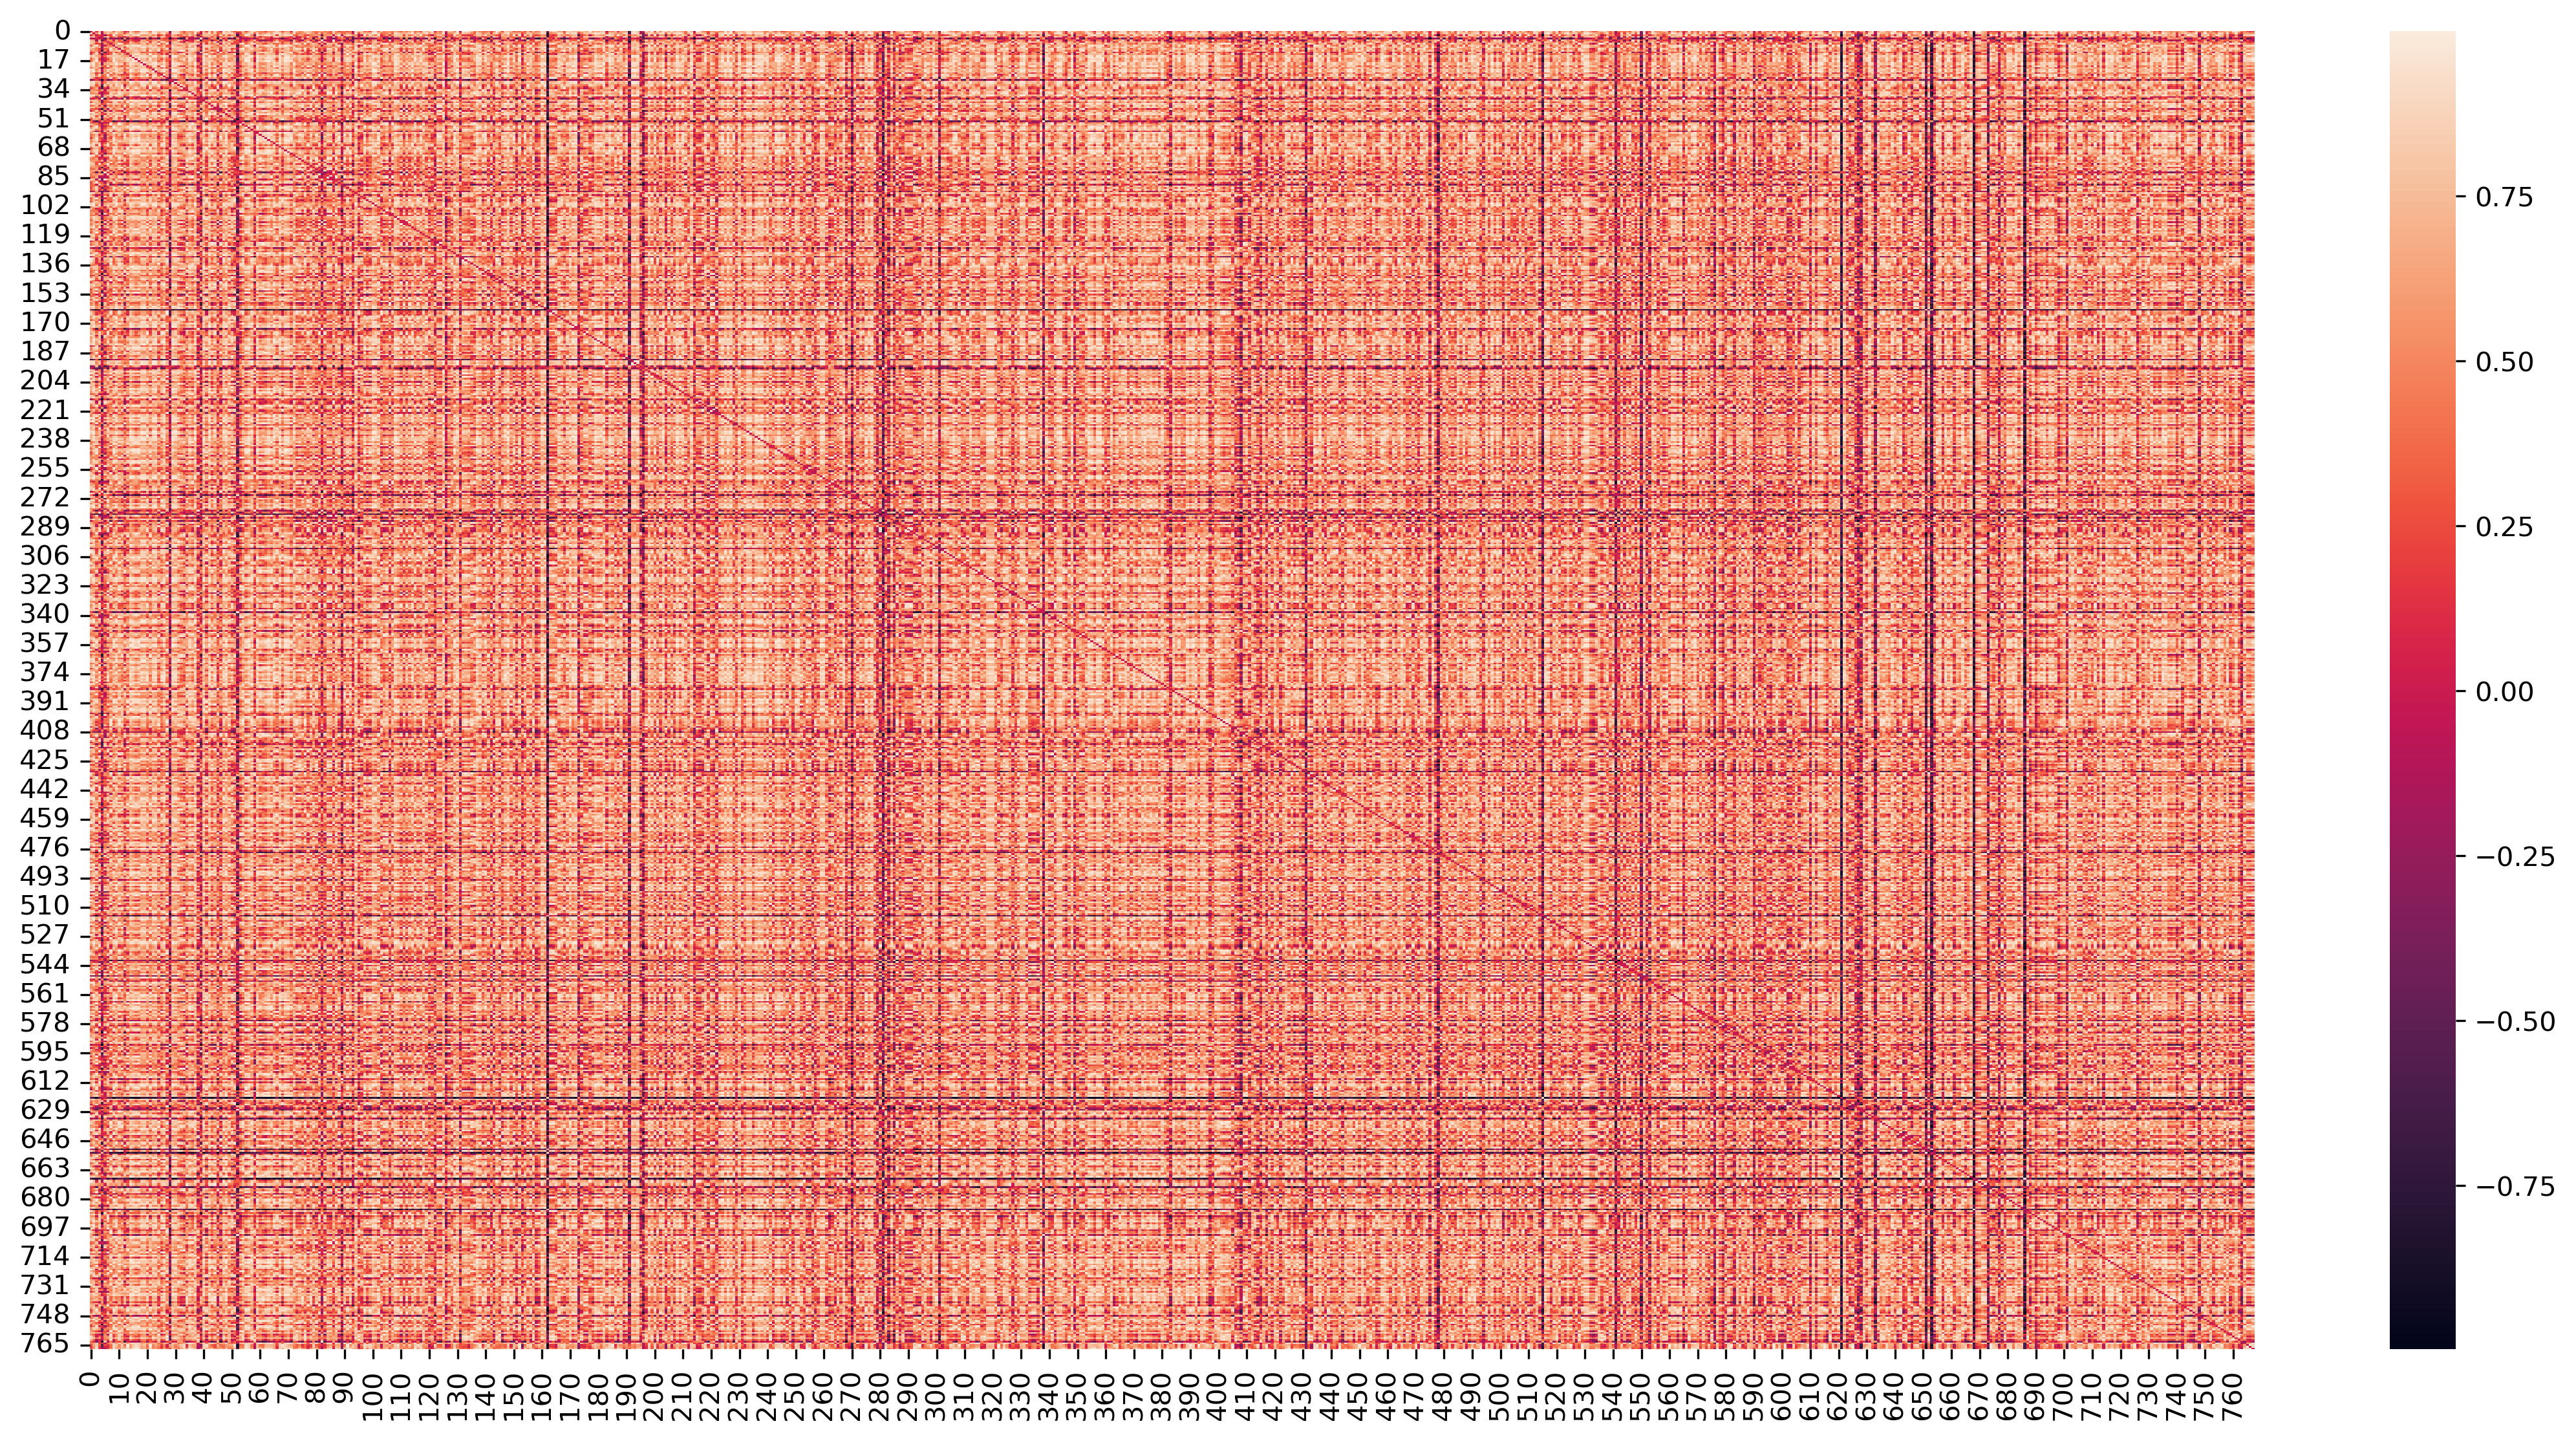

In [52]:
# build Doc2Vec embedding
docVectors = buildDocVectorMatrixByColumn(df, "ngram_lc_tagged_doc", vectorSize=4, minCount=1) # optimize the hyperparameters of this
docVecDF = pd.DataFrame(docVectors)

# Doc2Vec cosine similarity heatmap
cosSimMatrixDocs = buildAdjacencyMatrixByCosineSimilarity(docVectors)
figure(figsize=(18,9), dpi=300)
sns.heatmap(cosSimMatrixDocs)

##### TSNE Dimensional Reduction Visualization

/Users/ian/opt/anaconda3/envs/generalindexenv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/ian/opt/anaconda3/envs/generalindexenv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


Text(0.5, 1.0, 'T-SNE projection of the Doc2Vec Embedding')

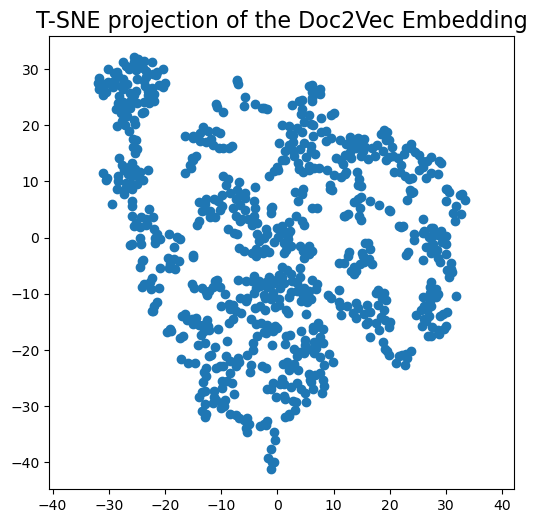

In [53]:
# TSNE Projection of n-dimensional document vectors to 2 dimensions
from sklearn.manifold import TSNE
projection = TSNE(init='pca').fit_transform(docVectors)
figure(figsize=(6,6), dpi=100)
plt.scatter(*projection.T)
plt.gca().set_aspect('equal', 'datalim')
plt.title('T-SNE projection of the Doc2Vec Embedding', fontsize=16)

### Uniform Manifold Approximation and Projection (UMAP) Dimensional Reduction

Text(0.5, 1.0, 'UMAP projection of the Doc2Vec Embedding')

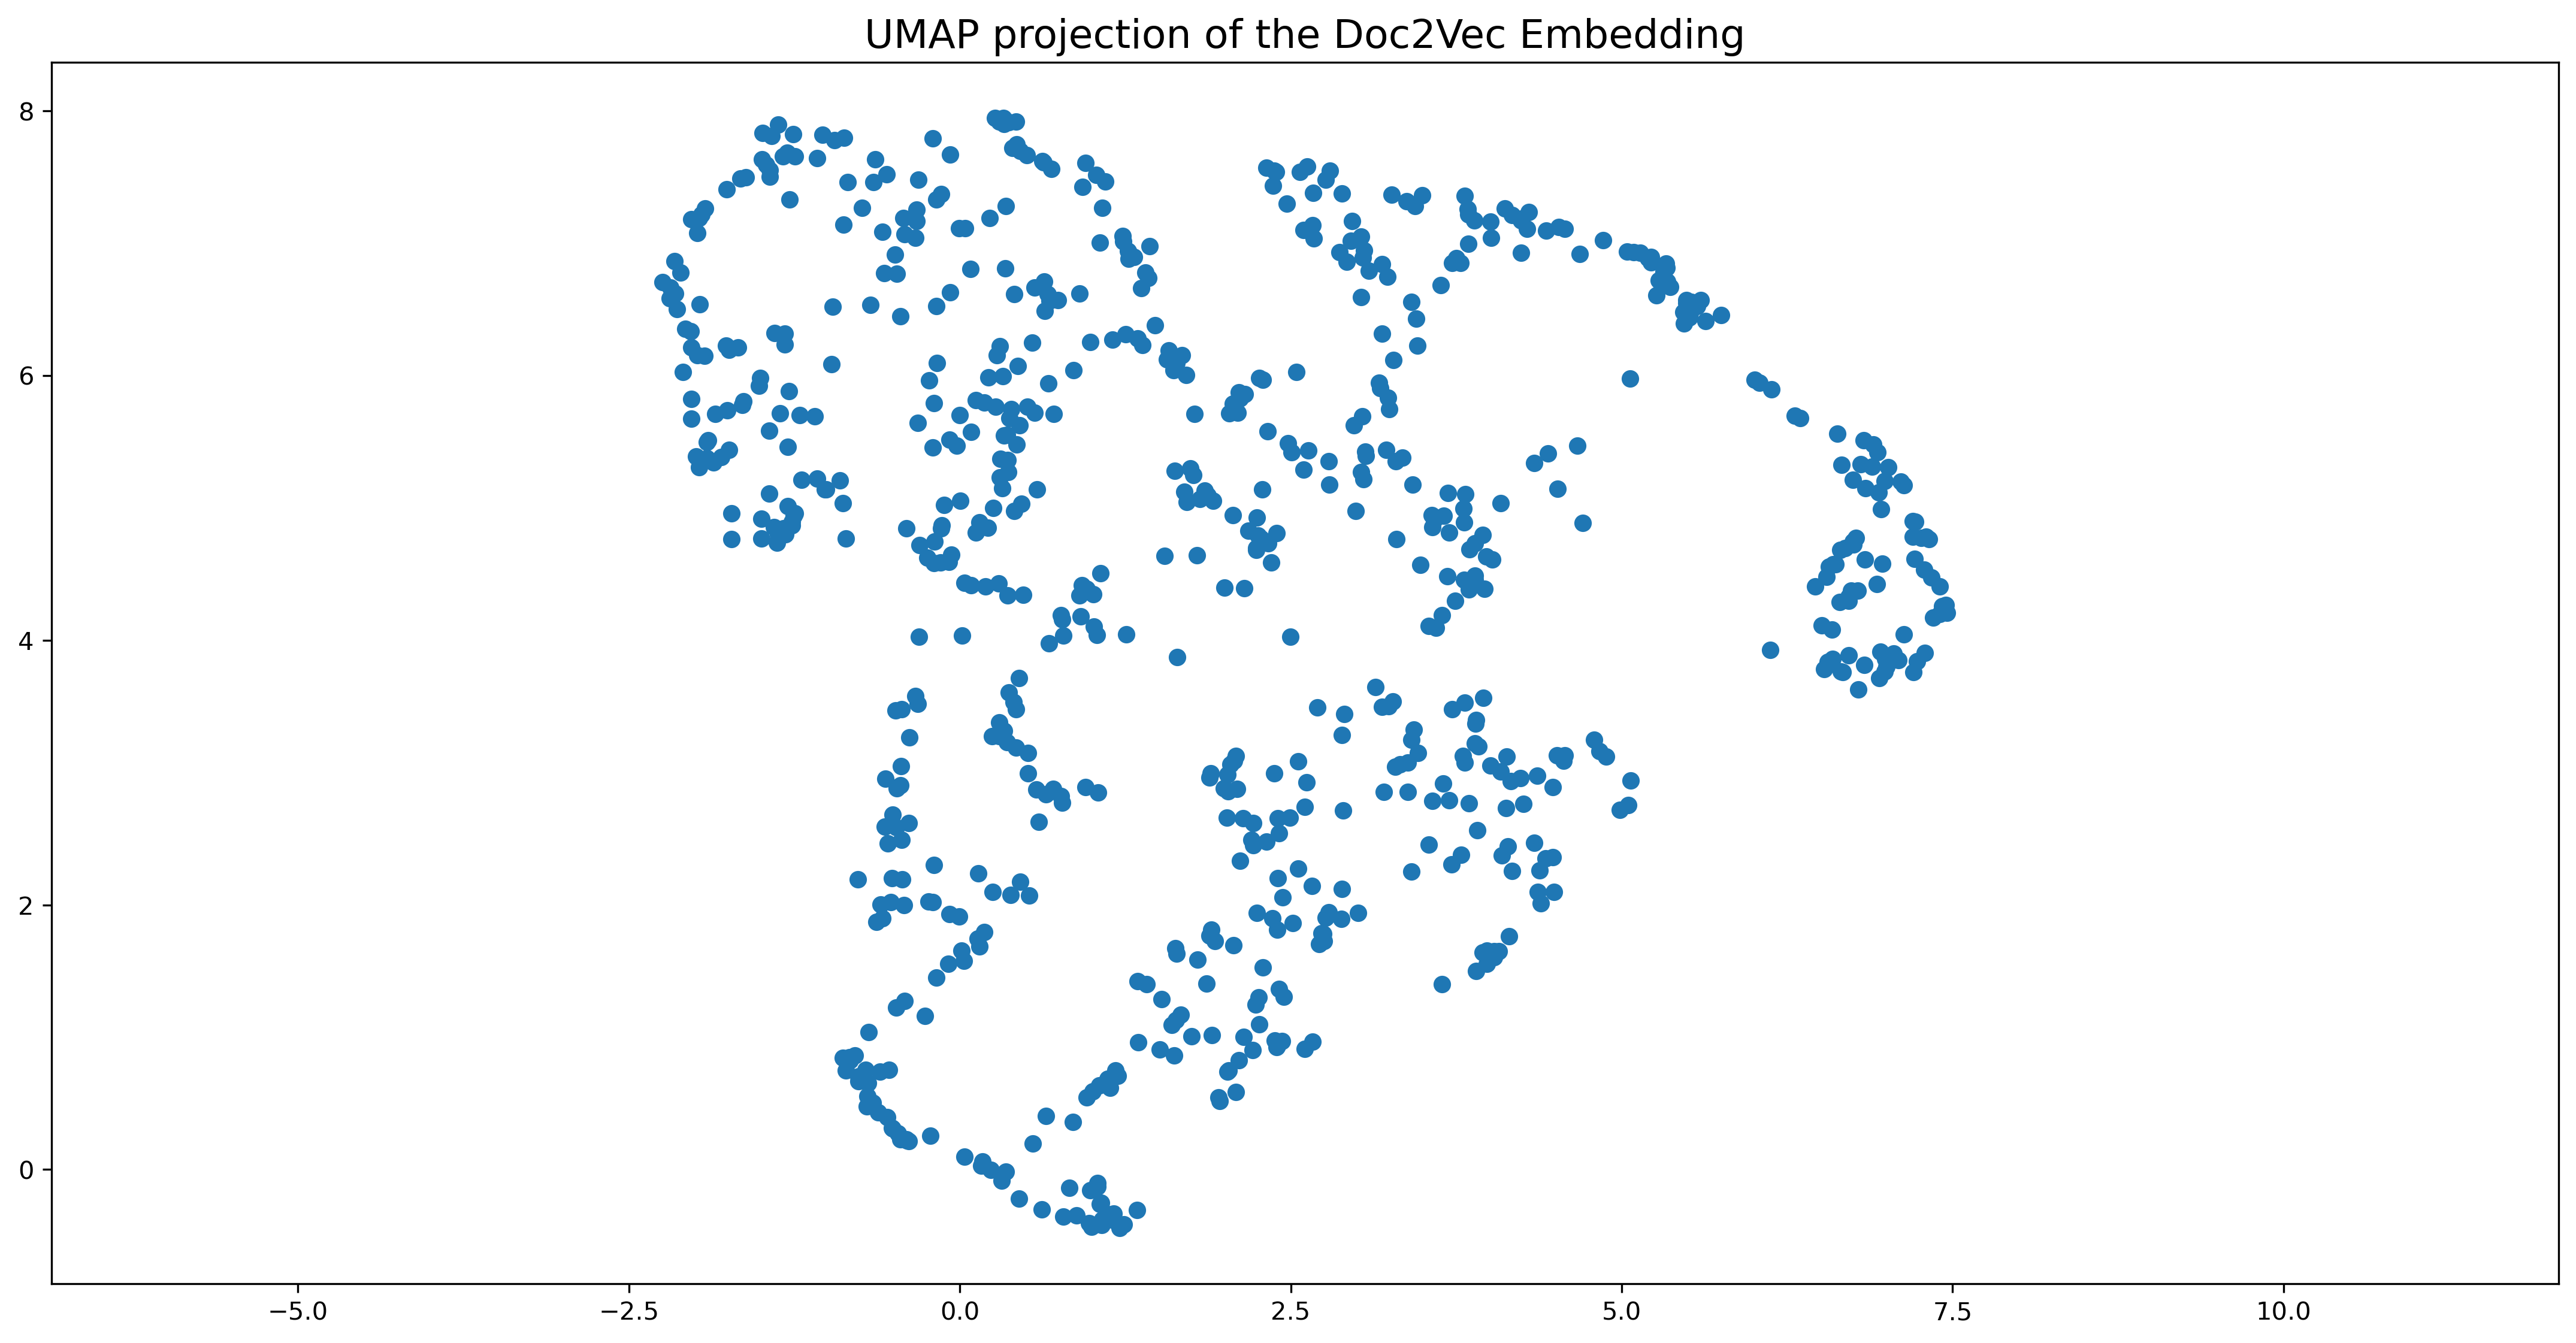

In [54]:
# UMAP
import umap

UMAP = umap.UMAP()
reducedEmbedding = UMAP.fit_transform(docVectors)
for n in range(reducedEmbedding.shape[1]):
    df["umap_embedding_" + str(n)] = reducedEmbedding[:,n] # add embeddings to dataframe
figure(figsize=(18,9), dpi=300)
plt.scatter(
    reducedEmbedding[:, 0],
    reducedEmbedding[:, 1],
    # figure out how to add colors from below (maybe after hdbscan)
    # c=[sns.color_palette()[x] for x in penguins.species_short.map({"Adelie":0, "Chinstrap":1, "Gentoo":2})])
)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Doc2Vec Embedding', fontsize=16)

### Hierarchical Density-Based Spatial Clustering of Applications with Noise (HDBSCAN)

Estimated number of clusters: 5
Estimated number of noise points: 10
Silhouette Coefficient: -0.094


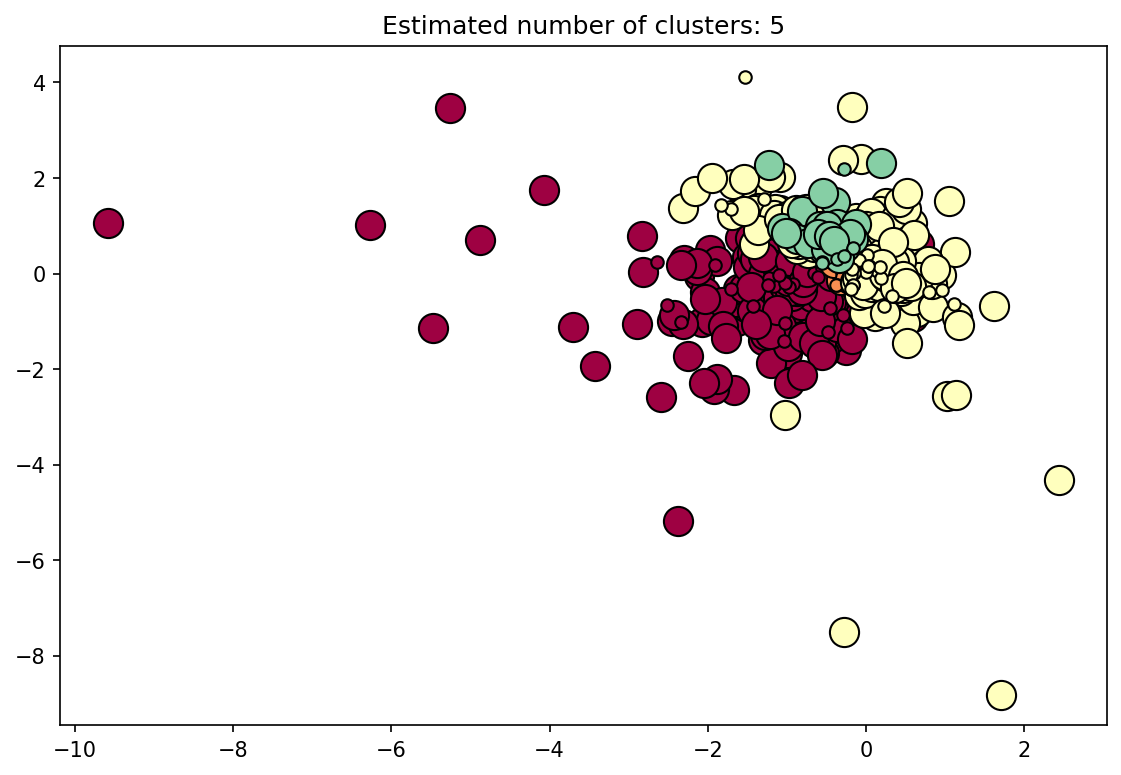

In [63]:
# DBSCAN, a single slice of HDBSCAN
from sklearn.cluster import DBSCAN
from sklearn import metrics

db = DBSCAN(eps=0.50, min_samples=10).fit(reducedEmbedding) # optimize hyperparameters, or just use HDBSCAN
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
unique_labels = set(labels)
n_clusters_ = len(labels) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % len(unique_labels))
print("Estimated number of noise points: %d" % n_noise_)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(docVectors, labels))

figure(figsize=(9,6), dpi=150)
# Black removed and is used for noise instead.

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]
        continue; # removes noise from plot
    class_member_mask = labels == k

    xy = docVectors[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = docVectors[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title("Estimated number of clusters: %d" % len(unique_labels))
plt.show()

Estimated number of clusters: 21
Estimated number of noise points: 174
Silhouette Coefficient: -0.044


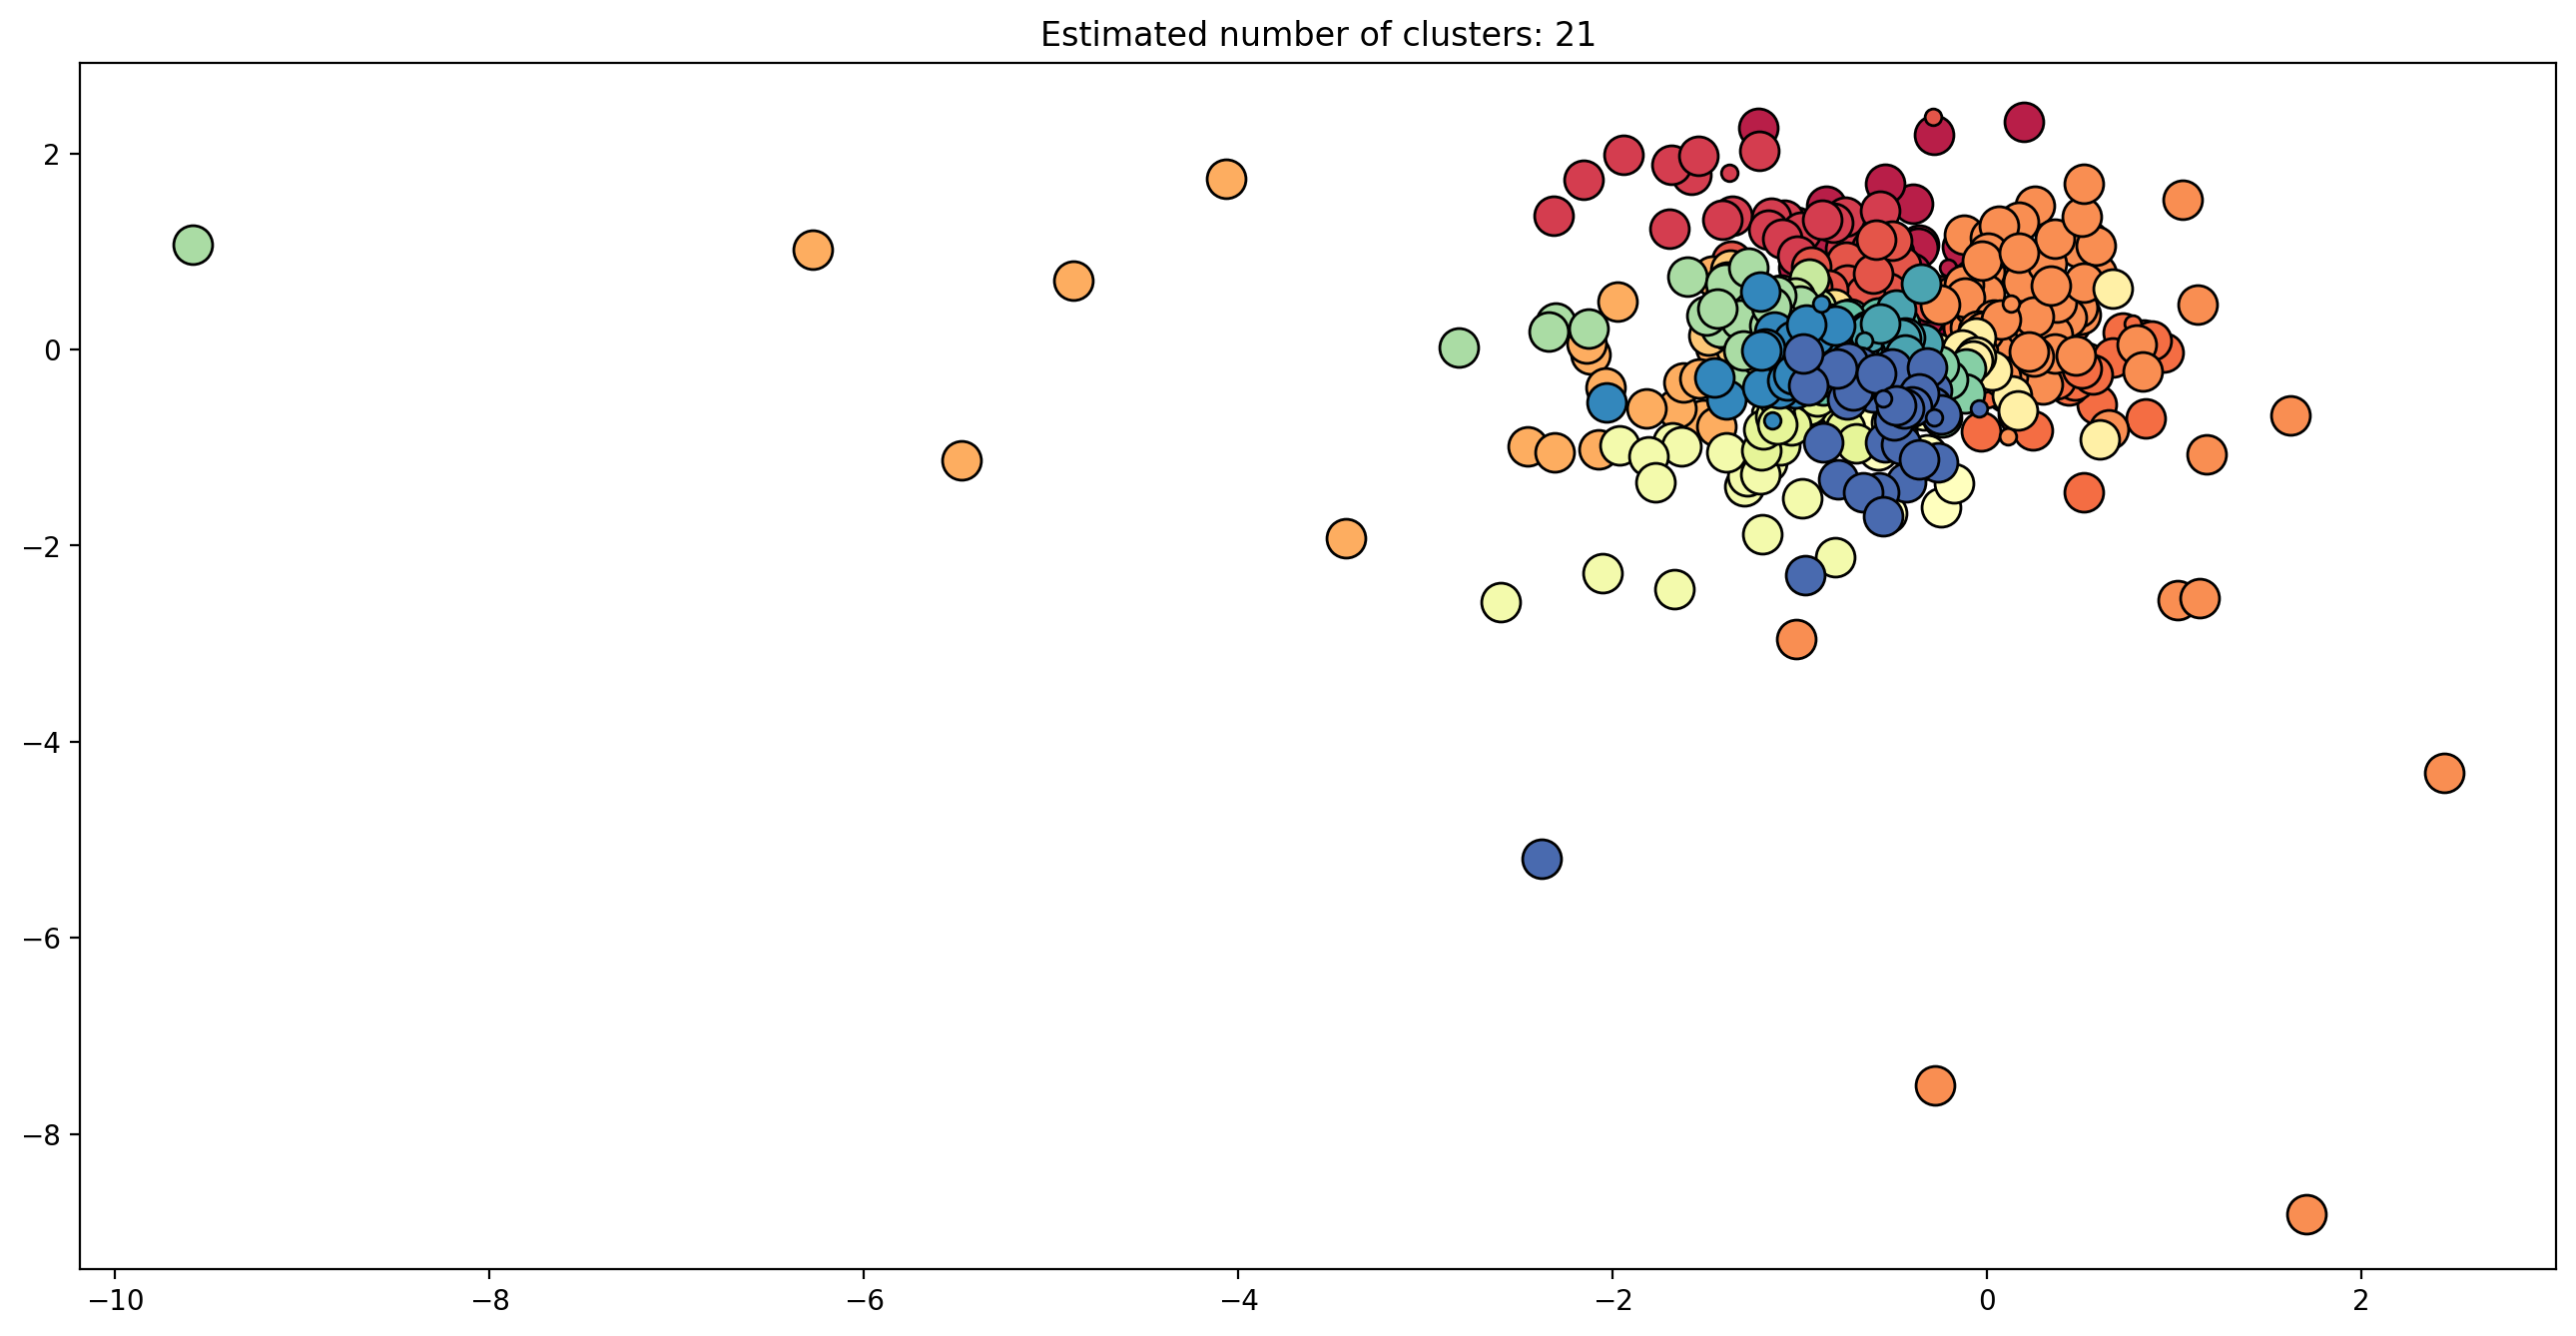

In [60]:
# HDBSCAN
import hdbscan
clusterer = hdbscan.HDBSCAN(min_cluster_size=10, gen_min_span_tree=True) # optimize hyperparameters
clusterer.fit(reducedEmbedding)
hdbscanLabels = clusterer.labels_
hdbscanProbabilities = clusterer.probabilities_
df["hdbscan_labels"] = hdbscanLabels
df["hdbscan_probabilities"] = hdbscanProbabilities

# Number of clusters in labels, ignoring noise if present.
unique_labels = set(hdbscanLabels)
n_clusters_ = len(hdbscanLabels) - (1 if -1 in hdbscanLabels else 0)
n_labels_ = len(unique_labels)
n_noise_ = list(hdbscanLabels).count(-1)

print("Estimated number of clusters: %d" % n_labels_)
print("Estimated number of noise points: %d" % n_noise_)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(docVectors, hdbscanLabels))


figure(figsize=(16,8), dpi=200)

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]
        continue; # removes noise from plot
    class_member_mask = hdbscanLabels == k

    xy = docVectors[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = docVectors[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title("Estimated number of clusters: %d" % n_labels_)
plt.show()

<AxesSubplot:>

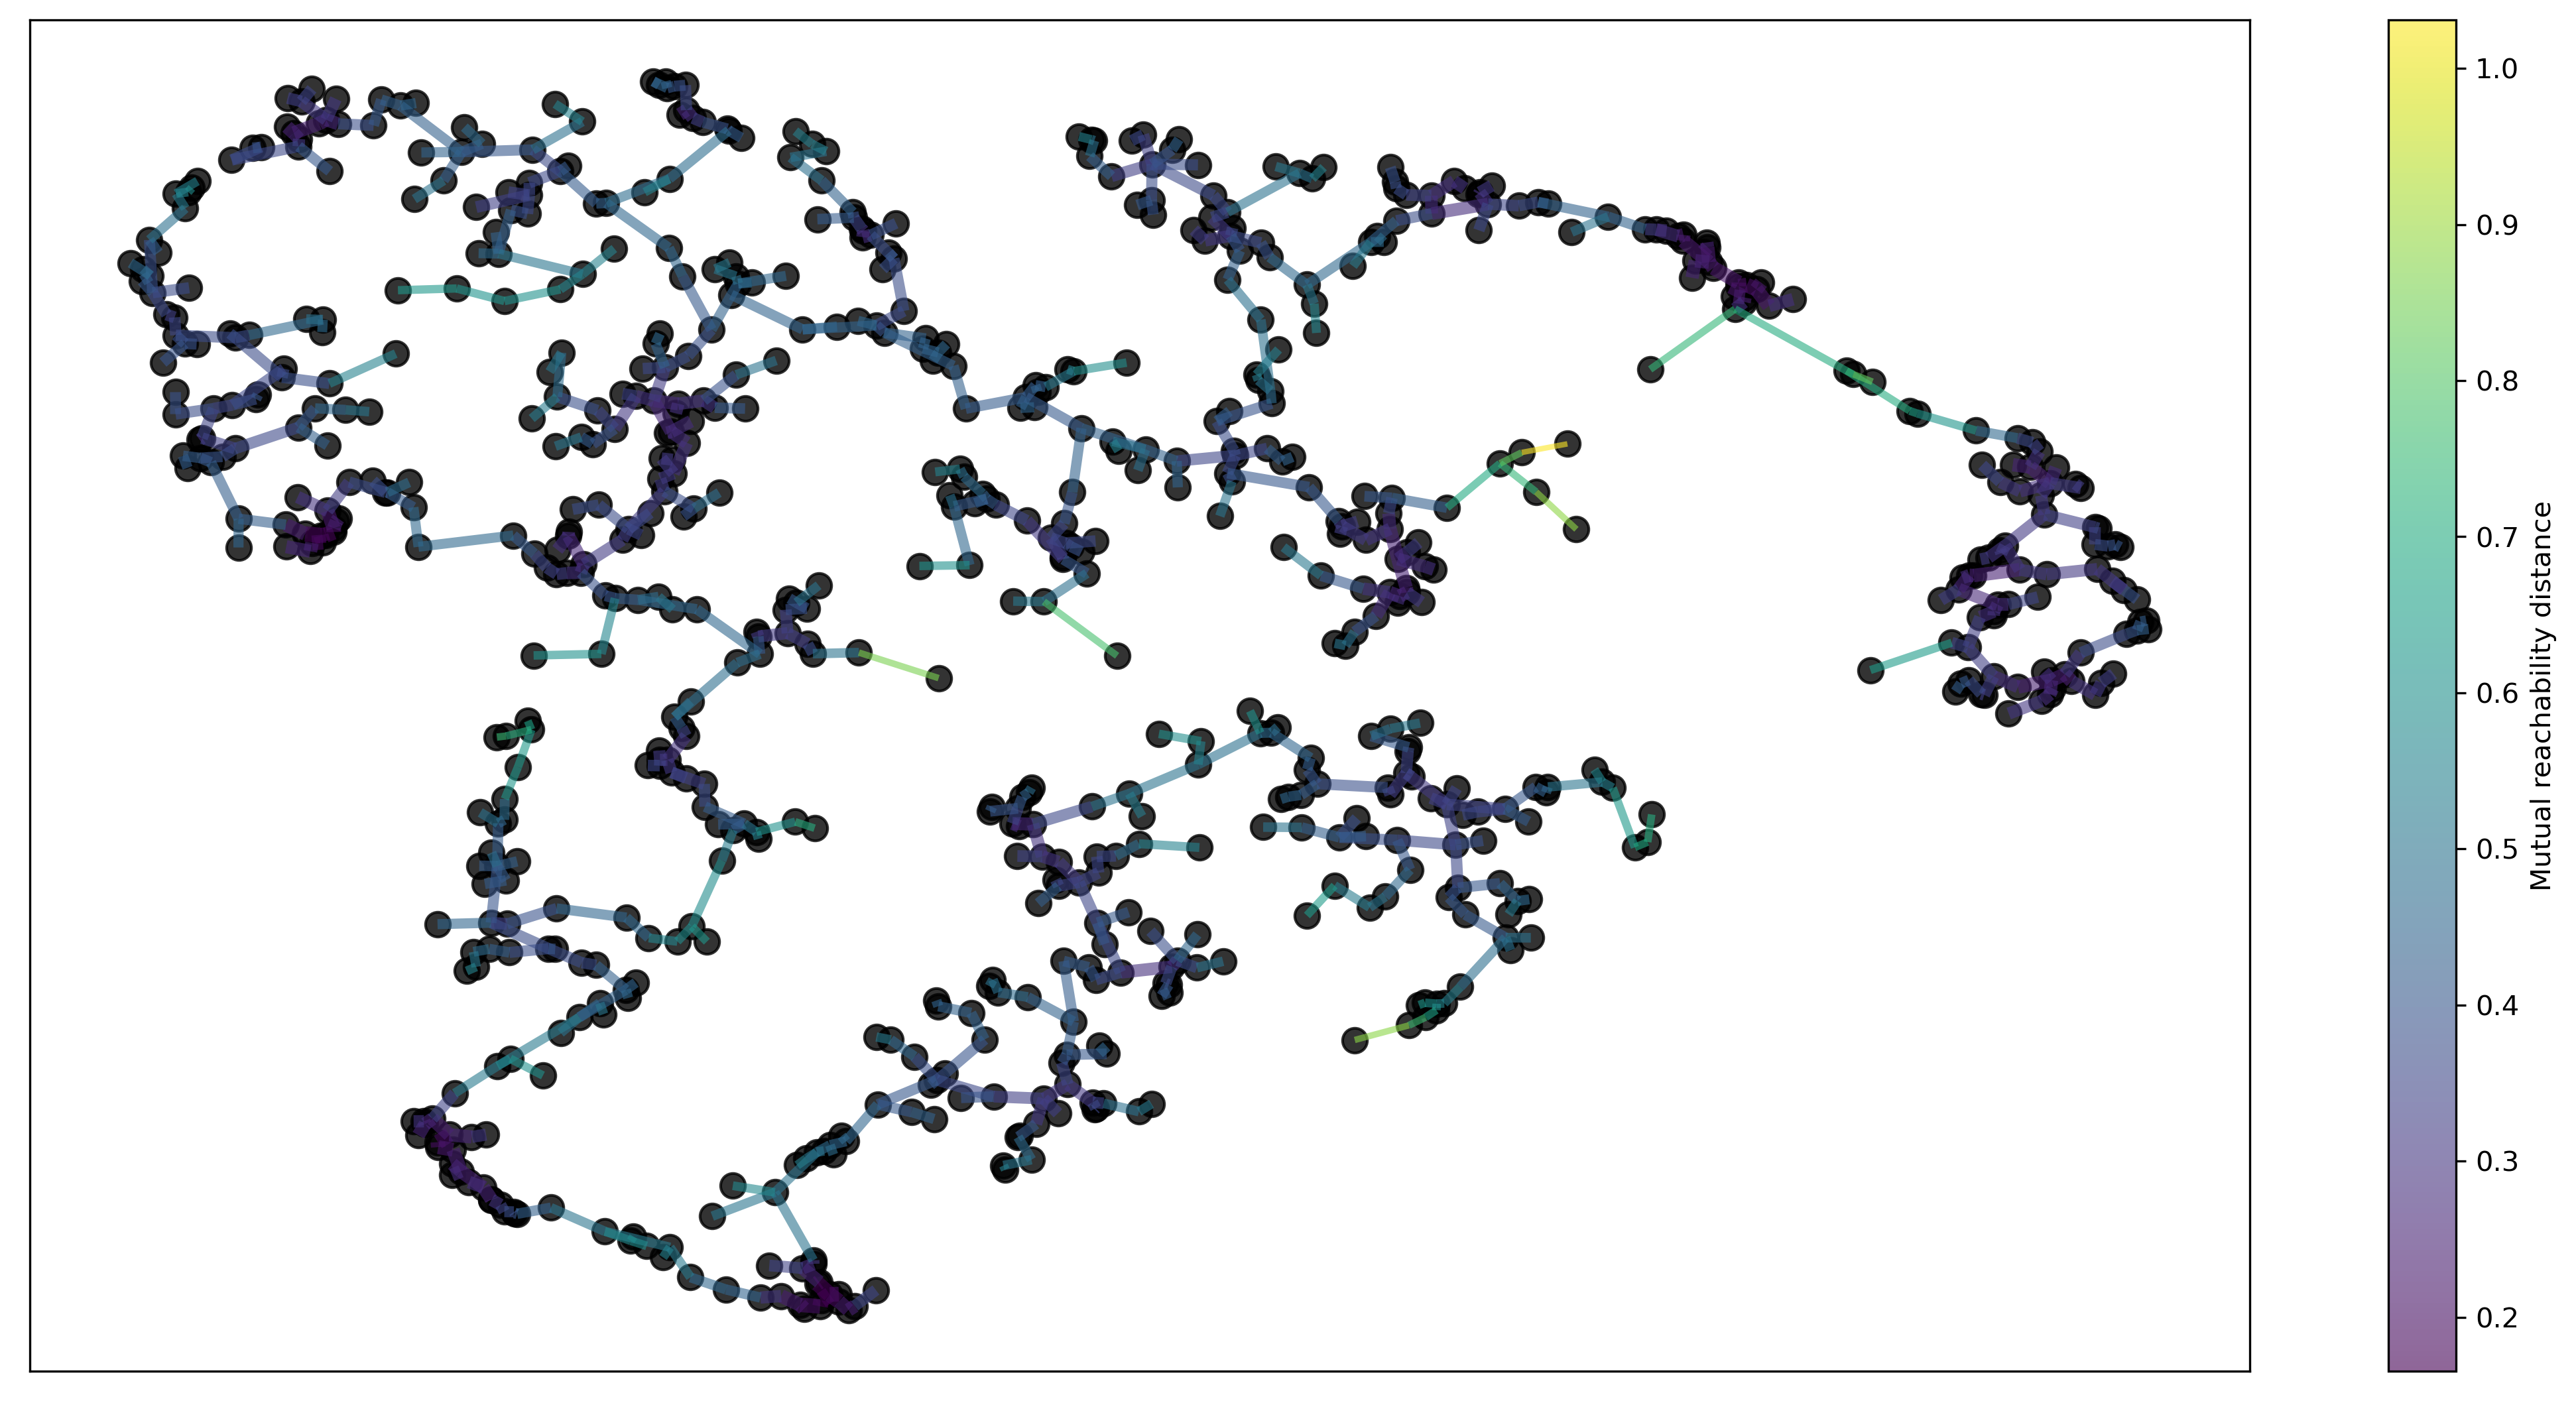

In [64]:
# visualize the minimum spanning tree
figure(figsize=(18,9), dpi=300)
clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis',
                                      edge_alpha=0.6,
                                      node_size=80,
                                      edge_linewidth=2)

<AxesSubplot:ylabel='distance'>

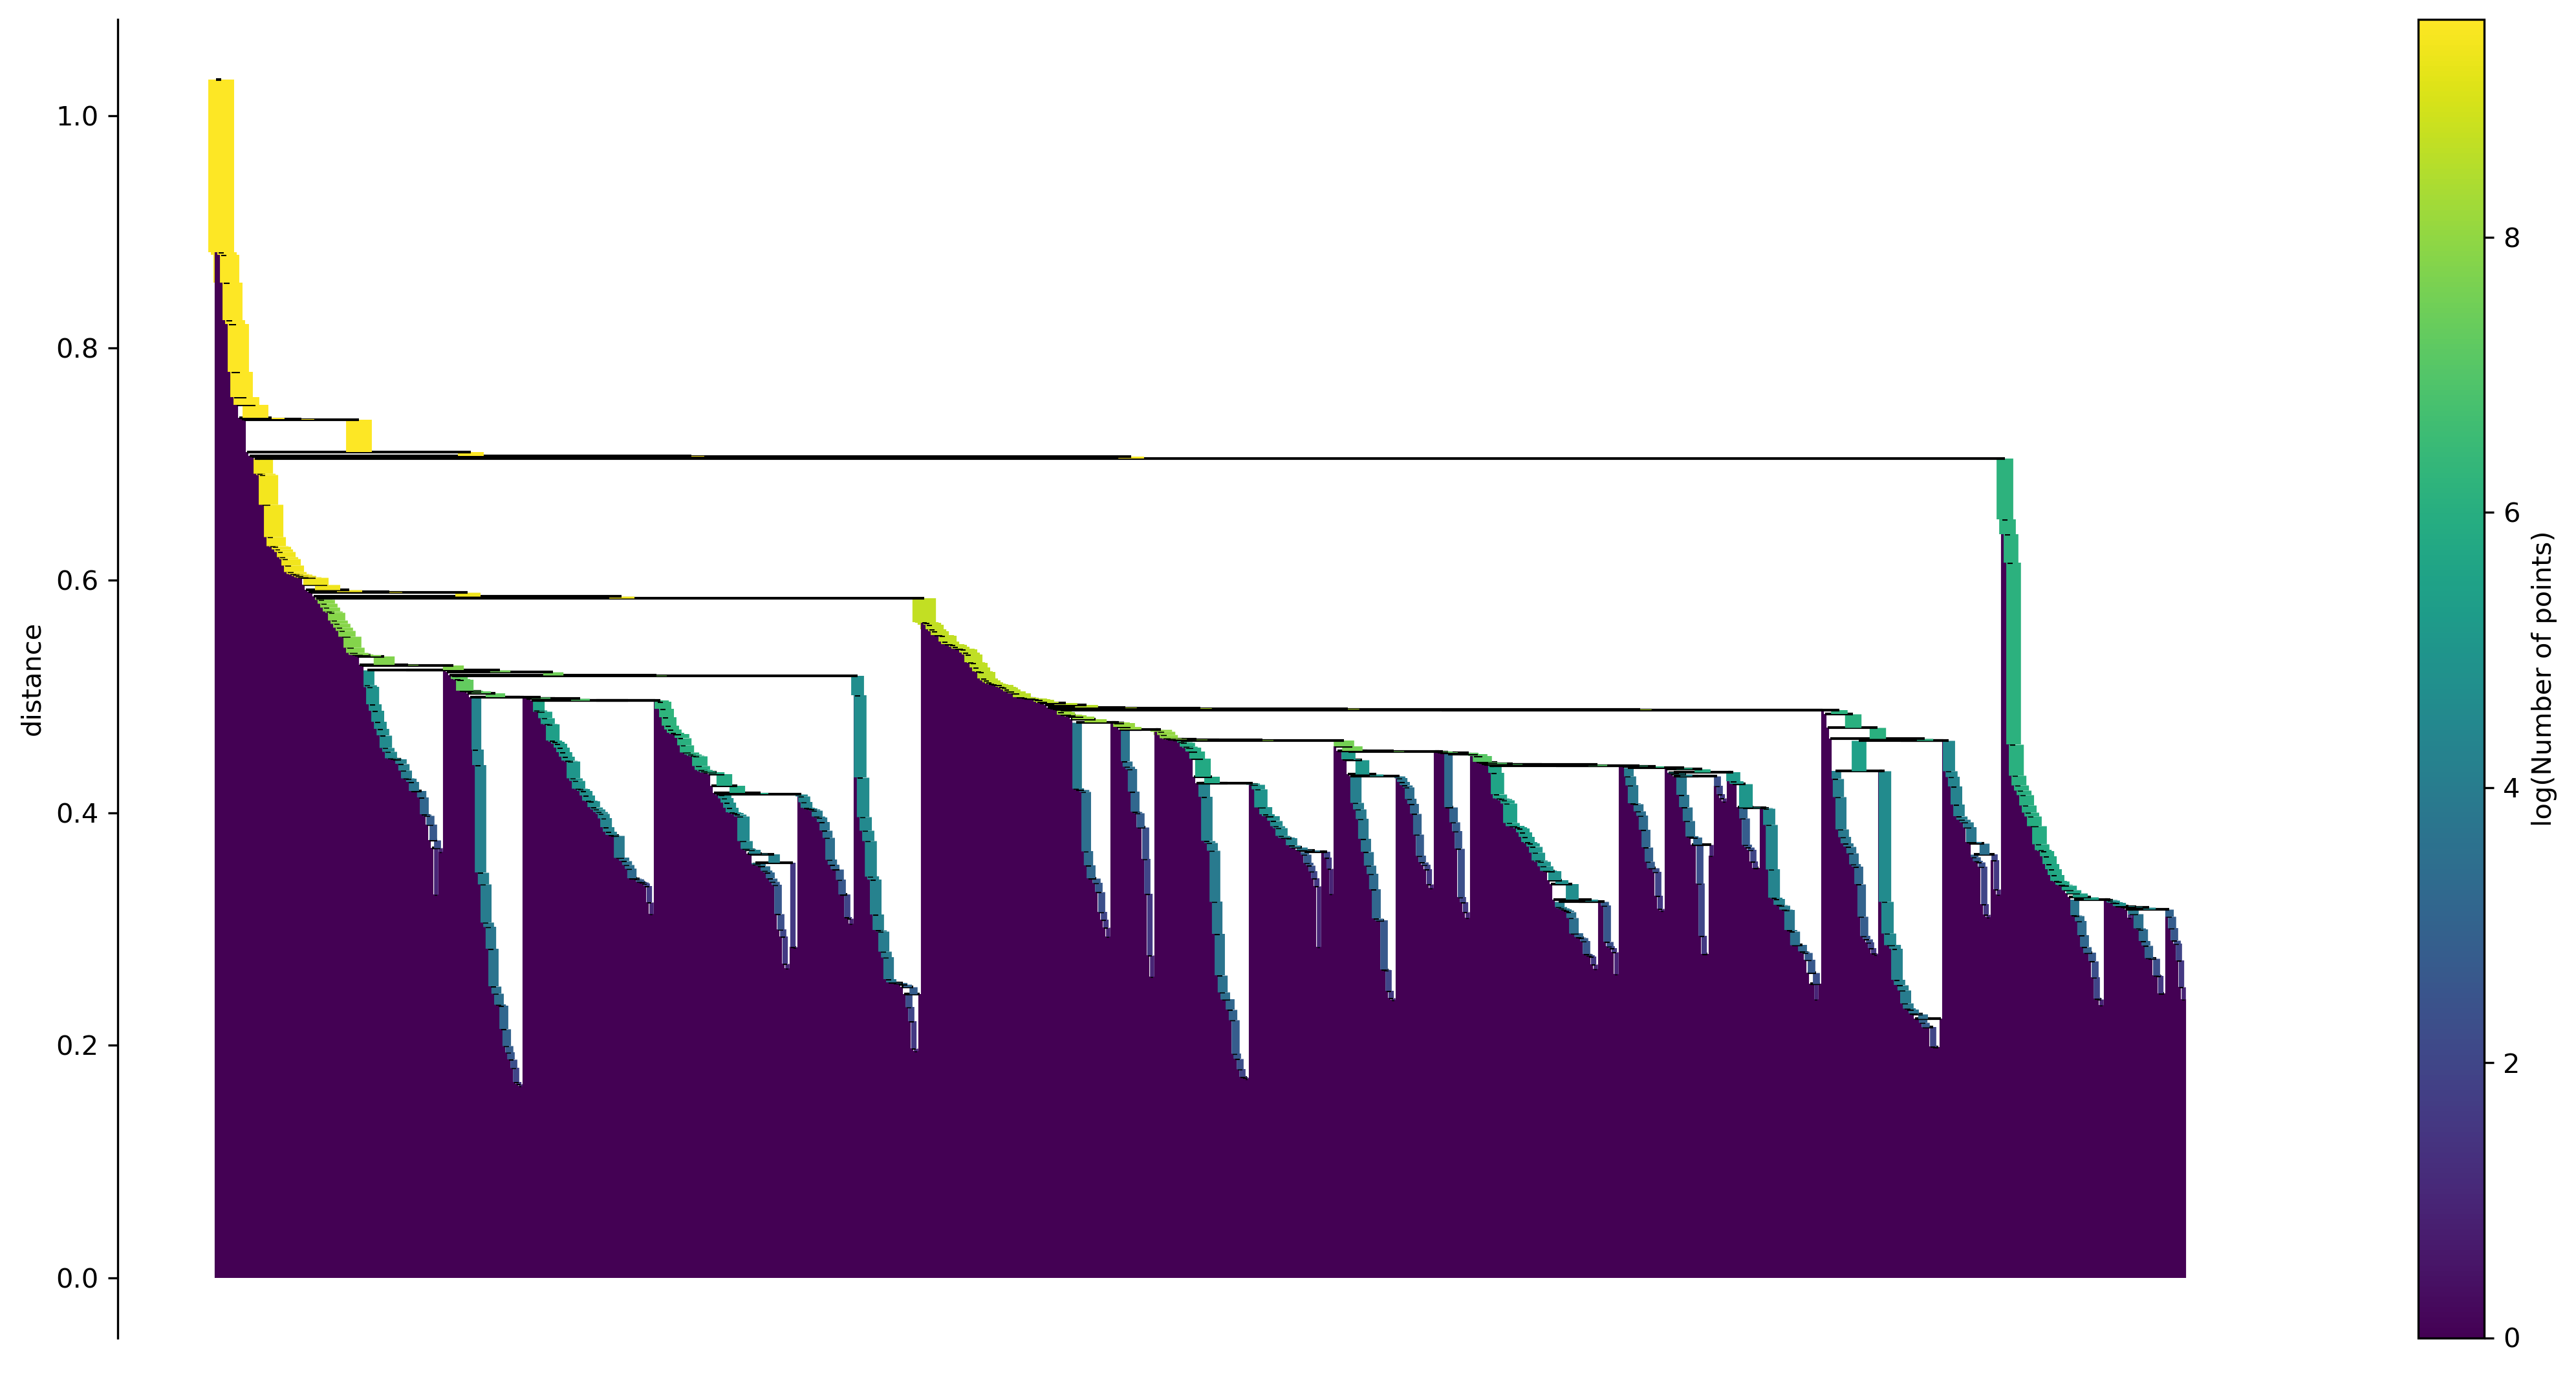

In [65]:
# visualize linkage tree
figure(figsize=(18,9), dpi=300)
clusterer.single_linkage_tree_.plot(cmap='viridis', colorbar=True)

### Class-based Term-Frequency Inverse-Document-Frequency (c-TF-IDF)

In [67]:
# group data by topic
dfTopic = df.copy(deep=True)
dfTopic = dfTopic.reset_index()
dfTopic = dfTopic.groupby("hdbscan_labels").agg(list)
dfTopic.head()

hash  \
hdbscan_labels                                                      
-1              [3005ebfe5508340797dbfcce8454f3d3f6f76eb1, 301...   
 0              [30136ab3788ab8e8be6b939901ec669a41ef896a, 301...   
 1              [3052a0a8c7ee498a53aa7558f3fae7335c6d205e, 315...   
 2              [30e4026a7075056c9f6b2533fc6d93e259ac8fa9, 315...   
 3              [30e507901bae33181edb63fb20c7278ce638564a, 319...   

                                                            ngram  \
hdbscan_labels                                                      
-1              [[antediluvian, antediluvian dream, cave of -P...   
 0              [[antediluvian], [Hennig86 software, analyse u...   
 1              [[antediluvian, party seem antediluvian, anted...   
 2              [[antediluvian, antediluvian ancestor, philoso...   
 3              [[antediluvian, antediluvian predecessor, reti...   

                                                         ngram_lc  \
hdbscan_labels                                                      
-1              [[antediluvian, antediluvian dream, cave of -p...   
 0              [[antediluvian], [hennig86 software, analyse u...   
 1              [[antediluvian, party seem antediluvian, anted...   
 2              [[antediluvian, antediluvian ancestor, philoso...   
 3              [[antediluvian, antediluvian predecessor, reti...   

                                                     ngram_tokens  \
hdbscan_labels                                                      
-1              [['1', '2', '4', '5', '5'], ['1', '2', '3', '3...   
 0              [['1'], ['2', '3', '4', '5', '1'], ['1'], ['1'...   
 1              [['1', '3', '3', '4', '4', '5'], ['5', '1', '2...   
 2              [['1', '2', '4', '5'], ['1', '2', '2', '3', '5...   
 3              [['1', '2', '4', '5'], ['2', '3', '4', '4', '5...   

                                                      ngram_count  \
hdbscan_labels                                                      
-1              [['1', '1', '1', '1', '1'], ['1', '1', '1', '1...   
 0              [['1'], ['1', '1', '1', '1', '1'], ['1'], ['1'...   
 1              [['1', '1', '1', '1', '1', '1'], ['1', '2', '1...   
 2              [['1', '1', '1', '1'], ['1', '1', '1', '1', '1...   
 3              [['1', '1', '1', '1'], ['1', '1', '1', '1', '1...   

                                                        term_freq  \
hdbscan_labels                                                      
-1              [9.109127345600292e-05, 0.0008583690987124, 0....   
 0              [5.075111652456354e-05, 8.034064433196755e-05,...   
 1              [0.0002058460271716, 0.0021739130434782, 3.203...   
 2              [0.0002415458937198, 0.0001269035532994, 2.026...   
 3              [0.0004837929366231, 0.0006079027355623, 0.000...   

                                                        doc_count  \
hdbscan_labels                                                      
-1              [['1', '1', '1', '1', '1'], ['1', '1', '1', '1...   
 0              [['1'], ['1', '1', '1', '1', '1'], ['1'], ['1'...   
 1              [['1', '1', '1', '1', '1', '1'], ['1', '1', '1...   
 2              [['1', '1', '1', '1'], ['1', '1', '1', '1', '1...   
 3              [['1', '1', '1', '1'], ['1', '1', '1', '1', '1...   

                                                       date_added  \
hdbscan_labels                                                      
-1              [['2021-09-03\n', '2021-09-03\n', '2021-09-03\...   
 0              [['\\N\n'], ['\\N\n', '\\N\n', '\\N\n', '\\N\n...   
 1              [['\\N\n', '\\N\n', '\\N\n', '\\N\n', '\\N\n',...   
 2              [['\\N\n', '\\N\n', '\\N\n', '\\N\n'], ['\\N\n...   
 3              [['\\N\n', '\\N\n', '\\N\n', '\\N\n'], ['\\N\n...   

                                                            topic  \
hdbscan_labels                                                      
-1              [antediluvian, antediluvian, antedi

In [100]:
# pull out TF-IDF vectors for each class/document

probabilities = clusterer.probabilities_
tfidfDict = {}
countVectDict = {}
docDict = {}
numTopics = len(dfTopic.index)-1 # skip topic -1: its designated for documents with no topic

for n in range(numTopics):
    documents = dfTopic.iloc[n]["ngram_lc_tagged_doc"]
    documentString = " ".join(documents) # is this necesary?
    clusterDict = {}
    cv = CountVectorizer()
    docCounts = cv.fit_transform(documents)
    tfidf_vectorizer = TfidfVectorizer()
    TfIdf = tfidf_vectorizer.fit_transform(documents)
    terms = list(tfidf_vectorizer.get_feature_names_out())
    for k in range(len(terms)):
        clusterDict[terms[k]] = TfIdf.data[k]
    tfidfDict[n] = clusterDict
    countVectDict[n] = docCounts.data
    docDict[n] = documents

### Maximize Marginal Relevance (MMR)

In [69]:
# https://medium.com/tech-that-works/maximal-marginal-relevance-to-rerank-results-in-unsupervised-keyphrase-extraction-22d95015c7c5
from sklearn.metrics.pairwise import cosine_similarity

def maximal_marginal_relevance(sentence_vector, phrases, embedding_matrix, lambda_constant=0.5, threshold_terms=10):
    """
    Return ranked phrases using MMR. Cosine similarity is used as similarity measure.
    :param sentence_vector: Query vector
    :param phrases: list of candidate phrases
    :param embedding_matrix: matrix having index as phrases and values as vector
    :param lambda_constant: 0.5 to balance diversity and accuracy. if lambda_constant is high, then higher accuracy. If lambda_constant is low then high diversity.
    :param threshold_terms: number of terms to include in result set
    :return: Ranked phrases with score
    """
    # todo: Use cosine similarity matrix for lookup among phrases instead of making call everytime.
    s = []
    r = sorted(phrases, key=lambda x: x[1], reverse=True)
    r = [i[0] for i in r]
    while len(r) > 0:
        score = 0
        phrase_to_add = ''
        for i in r:
            first_part = cosine_similarity([sentence_vector], [embedding_matrix.loc[i]])[0][0]
            second_part = 0
            for j in s:
                cos_sim = cosine_similarity([embedding_matrix.loc[i]], [embedding_matrix.loc[j[0]]])[0][0]
                if cos_sim > second_part:
                    second_part = cos_sim
            equation_score = lambda_constant*(first_part)-(1-lambda_constant) * second_part
            if equation_score > score:
                score = equation_score
                phrase_to_add = i
        if phrase_to_add == '':
            phrase_to_add = i
        r.remove(phrase_to_add)
        s.append((phrase_to_add, score))
    return (s, s[:threshold_terms])[threshold_terms > len(s)]

In [97]:
# https://maartengr.github.io/KeyBERT/api/mmr.html#keybert._mmr.mmr
import numpy as np
from operator import itemgetter
from typing import List, Tuple
from sklearn.metrics.pairwise import cosine_similarity

def mmr(
    doc_embedding: np.ndarray,
    word_embeddings: np.ndarray,
    words: List[str],
    top_n: int = 5,
    diversity: float = 0.8,
) -> List[Tuple[str, float]]:
    """Calculate Maximal Marginal Relevance (MMR)
    between candidate keywords and the document.


    MMR considers the similarity of keywords/keyphrases with the
    document, along with the similarity of already selected
    keywords and keyphrases. This results in a selection of keywords
    that maximize their within diversity with respect to the document.

    Arguments:
        doc_embedding: The document embeddings
        word_embeddings: The embeddings of the selected candidate keywords/phrases
        words: The selected candidate keywords/keyphrases
        top_n: The number of keywords/keyhprases to return
        diversity: How diverse the select keywords/keyphrases are.
                   Values between 0 and 1 with 0 being not diverse at all
                   and 1 being most diverse.

    Returns:
         List[Tuple[str, float]]: The selected keywords/keyphrases with their distances

    """

    # Extract similarity within words, and between words and the document
    word_doc_similarity = cosine_similarity(word_embeddings, doc_embedding)
    word_similarity = cosine_similarity(word_embeddings)

    # Initialize candidates and already choose best keyword/keyphras
    keywords_idx = [np.argmax(word_doc_similarity)]
    candidates_idx = [i for i in range(len(words)) if i != keywords_idx[0]]

    for _ in range(min(top_n - 1, len(words) - 1)):
        # Extract similarities within candidates and
        # between candidates and selected keywords/phrases
        candidate_similarities = word_doc_similarity[candidates_idx, :]
        target_similarities = np.max(
            word_similarity[candidates_idx][:, keywords_idx], axis=1
        )

        # Calculate MMR
        mmr = (
            1 - diversity
        ) * candidate_similarities - diversity * target_similarities.reshape(-1, 1)
        mmr_idx = candidates_idx[np.argmax(mmr)]

        # Update keywords & candidates
        keywords_idx.append(mmr_idx)
        candidates_idx.remove(mmr_idx)

    # Extract and sort keywords in descending similarity
    keywords = [
        (words[idx], round(float(word_doc_similarity.reshape(1, -1)[0][idx]), 4))
        for idx in keywords_idx
    ]
    keywords = sorted(keywords, key=itemgetter(1), reverse=True)
    return keywords


In [114]:
numTopics = len(dfTopic.index)-1 # skip topic -1: its designated for documents with no topic
keywordDict = {}

for n in range(numTopics):
    tfidfArray = np.array(list(tfidfDict[n].values()))
    wordArray = np.array(list(tfidfDict[n].keys()))
    keywords = mmr(docVectors, tfidfArray, wordArray)
    keywordDict[n] = keywords

ValueError: Expected 2D array, got 1D array instead:
array=[0.23930814 0.77538263 0.51692175 0.27258999 0.35517305 0.32885365
 0.82213412 0.29967126 0.26071489 0.52142978 0.78214466 0.21997378
 0.88435844 0.46680847 0.52460595 0.52460595 0.56659216 0.35853942
 0.64543865 0.64543865 0.40843346 0.66552578 0.61620829 0.4211446
 0.25723758 0.77171274 0.51447516 0.27129982 0.26071489 0.52142978
 0.78214466 0.21997378 0.43031413 0.86062825 0.2723027  0.41417273
 0.41417273 0.76696255 0.26208843 0.25228176 0.25228176 0.50456351
 0.75684527 0.21285847 0.89201538 0.45200505 0.92136695 0.38869389
 0.11433625 0.12348702 0.12348702 0.12348702 0.12348702 0.37046105
 0.37046105 0.37046105 0.37046105 0.49394807 0.36466529 0.67760081
 0.67760081 0.28585711 0.26071489 0.52142978 0.78214466 0.21997378
 0.581656   0.77554133 0.24538121 0.25228176 0.25228176 0.75684527
 0.50456351 0.21285847 0.16740555 0.15500029 0.16740555 0.31000058
 0.3348111  0.50221665 0.15500029 0.55748603 0.35311401 0.15002634
 0.28301422 0.64813406 0.64813406 0.23924782 0.3590113  0.59628386
 0.7180226  0.16473874 0.32947748 0.32947748 0.8236937  0.27799105
 0.61927692 0.78517265 0.60397188 0.72527056 0.33045512 0.83576159
 0.46386894 0.29381655 0.23932605 0.23932605 0.22159126 0.4786521
 0.71797815 0.30289096 0.25723758 0.51447516 0.77171274 0.27129982
 0.88435844 0.46680847 0.35176692 0.32569992 0.52765038 0.65139984
 0.25969772 0.67760081 0.67760081 0.28585711 0.53239108 0.79858662
 0.28074748 0.23270964 0.69812892 0.60968995 0.29451724 0.43777866
 0.43777866 0.7853023  0.43031413 0.86062825 0.2723027  0.06359176
 0.06359176 0.06359176 0.06359176 0.06359176 0.12718352 0.06359176
 0.19077528 0.06359176 0.06359176 0.06359176 0.06359176 0.06359176
 0.19077528 0.12718352 0.06359176 0.05887942 0.06359176 0.25436704
 0.19077528 0.19077528 0.19077528 0.12718352 0.29439708 0.33321573
 0.06359176 0.19077528 0.25436704 0.19077528 0.14709619 0.53654472
 0.67760081 0.67760081 0.28585711 0.90999428 0.41462081 0.90999428
 0.41462081 0.08875155 0.1775031  0.1775031  0.26625465 0.44375774
 0.16434958 0.46505102 0.24652436 0.51722335 0.29953047 0.8450228
 0.53473028 0.4184179  0.83683579 0.35303303 0.89201538 0.45200505
 0.38465898 0.71230915 0.53423186 0.24341213 0.20397789 0.40795578
 0.40795578 0.40795578 0.67757602 0.72527056 0.60397188 0.33045512
 0.26700149 0.44457785 0.61760991 0.59128567 0.39975316 0.79950633
 0.37013024 0.25296373 0.35737623 0.35737623 0.29752934 0.55110579
 0.59356816 0.92136695 0.38869389 0.90999428 0.41462081 0.40830575
 0.7560981  0.37804905 0.34450107 0.18028143 0.17004417 0.36056286
 0.36056286 0.51013251 0.64678996 0.39527126 0.79054251 0.39527126
 0.25012758 0.26071489 0.52142978 0.78214466 0.21997378 0.88435844
 0.46680847 0.92136695 0.38869389 0.11055781 0.20473028 0.66334688
 0.66334688 0.25652353 0.67760081 0.67760081 0.28585711 0.25430022
 0.58921622 0.55575765 0.52847808 0.23683728 0.47367455 0.47367455
 0.65786073 0.24978431 0.67303852 0.67303852 0.30665663 0.1506815
 0.1506815  0.4263752  0.28425014 0.39019637 0.14212507 0.72079364
 0.73105917 0.60863465 0.30840941 0.24860436 0.49720871 0.74581307
 0.36707252 0.17614235 0.17614235 0.52842704 0.70456939 0.30765727
 0.26007997 0.46994057 0.46994057 0.70491086 0.24781526 0.38599149
 0.77198298 0.38599149 0.32567379 0.36154047 0.72308094 0.5423107
 0.22878274 0.43031413 0.86062825 0.2723027  0.67303852 0.67303852
 0.30665663 0.54575762 0.54575762 0.57861415 0.26363404 0.43031413
 0.86062825 0.2723027  0.92136695 0.38869389 0.92136695 0.38869389
 0.65133961 0.68324546 0.33004901 0.51692175 0.77538263 0.23930814
 0.27258999 0.25723758 0.51447516 0.77171274 0.27129982 0.87223043
 0.40379775 0.27597363 0.4463211  0.4463211  0.74386851 0.21966927
 0.31473758 0.68783981 0.65407695 0.90999428 0.41462081 0.3590113
 0.7180226  0.59628386 0.48953105 0.81510656 0.30977516 0.43031413
 0.86062825 0.2723027  0.5310524  0.2655262  0.46377869 0.40946492
 0.51451627 0.43031413 0.86062825 0.2723027  0.52931761 0.52931761
 0.49009356 0.44660278 0.4463211  0.74386851 0.4463211  0.21966927
 0.38629949 0.67472614 0.57944923 0.24445025 0.21301956 0.63905868
 0.63905868 0.19723416 0.31453039 0.18068384 0.16729462 0.58553116
 0.54205152 0.55018112 0.30553927 0.91661781 0.25779359 0.67760081
 0.67760081 0.28585711 0.9534154  0.30166054 0.13125146 0.13125146
 0.26250293 0.26250293 0.39375439 0.26250293 0.39375439 0.54635926
 0.38759421 0.43031413 0.86062825 0.2723027  0.77110654 0.26962639
 0.47610014 0.32561476 0.42552436 0.35426527 0.78798342 0.26927174
 0.8450228  0.53473028 0.43031413 0.86062825 0.2723027  0.17407766
 0.17407766 0.17407766 0.17407766 0.52223297 0.69631062 0.34815531
 0.67760081 0.67760081 0.28585711 0.71783621 0.62690072 0.30283108
 0.45503572 0.84263236 0.28794652 0.92136695 0.38869389 0.38434139].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [70]:
# figure out how to use above code to extract topic keywords


### Building Networks

In [ ]:
print("Building Networkx Graphs...")
t0 = time()
Gcossim = nx.from_numpy_array(cosSimMatrixDocs)
print("Done in %0.3fs.\n" % (time() - t0))

In [ ]:
print("Adding Node Metadata...")
t0 = time()
numCommunities = 0
numNodes = len(df)
nodes = list(range(numNodes))
scalingFactor = 5. # scales the node size for visibility
communitySets = communitySetsCossineSim
G = Gcossim
adjMatrix = cosSimMatrixDocs

node_to_community = {}

for set in communitySets:
    for x in set:
        node_to_community[x] = numCommunities
    numCommunities = numCommunities + 1

for n in nodes:
    # 'title': hash (i.e. dataframe index)
    # 'group': partition
    # 'value': topic (empty for now)
    # 'size': normalized YAKE score
    G.nodes[n]["title"] = df.index[n] # this (clearly) doesn't work for matrices based on words (e.g. cooccurence)
    G.nodes[n]["group"] = node_to_community[n]
    G.nodes[n]["size"] = df["normalized_term_freq"][n] * scalingFactor
print("Done in %0.3fs.\n" % (time() - t0))

##### Network/Topic Visualization

PyVis

In [ ]:
# input the network you would like to visualize below as a NetworkX object in the first parameter
# recommended to only run this after validating the network with the above graphs and statistics
# if it is taking a while to run/load the image, set _physics=False
visualizeNetworkHTML(Gcossim, _filename="test vector cosine.html", _width="3840px", _height="2160px", _physics=True)

Key nodes

In [2]:
# bridge node
df.loc["3bad1c0f3b983ab81ddff3f5e90e687310269d16"]

NameError: name 'df' is not defined